# start

## importing

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from patsy import dmatrix

sns.set_context("talk")
sns.set_style("whitegrid")
sns.set_palette("colorblind")

import math

from scipy.stats import ttest_ind, mannwhitneyu, shapiro, chi2

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

from sklearn.utils import resample
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, roc_auc_score, roc_curve,
  confusion_matrix, classification_report, precision_recall_curve, f1_score, make_scorer, precision_score, recall_score, average_precision_score)

!pip install lifelines
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.utils import concordance_index, restricted_mean_survival_time
from lifelines.statistics import proportional_hazard_test, logrank_test

"""from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")

from scipy.stats import shapiro, mannwhitneyu, ttest_ind
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report, make_scorer
from sklearn.calibration import CalibrationDisplay

from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored
from sksurv.util import Surv
from sklearn.inspection import permutation_importance

!pip install pyreadstat
import pyreadstat

!pip install lifelines
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.utils import concordance_index, restricted_mean_survival_time

!pip install scikit-survival
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored
from sksurv.util import Surv"""

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 5.5 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=1f63730ff04ea06332145a137064fc7610dae3e83bfbfb0f1ac00d0f19fc892c
  Stored in directory: /root/.cache/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma


'from xgboost import XGBClassifier\nimport warnings\nwarnings.filterwarnings("ignore", category=UserWarning, module="xgboost")\n\nfrom scipy.stats import shapiro, mannwhitneyu, ttest_ind\nfrom sklearn.model_selection import train_test_split, RandomizedSearchCV\nfrom sklearn.linear_model import LogisticRegression\nfrom sklearn.preprocessing import StandardScaler\nfrom sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report, make_scorer\nfrom sklearn.calibration import CalibrationDisplay\n\nfrom sksurv.ensemble import RandomSurvivalForest\nfrom sksurv.metrics import concordance_index_censored\nfrom sksurv.util import Surv\nfrom sklearn.inspection import permutation_importance\n\n!pip install pyreadstat\nimport pyreadstat\n\n!pip install lifelines\nfrom lifelines import CoxPHFitter, KaplanMeierFitter\nfrom lifelines.utils import concordance_index, restricted_mean_survival_time\n\n!pip install scikit-survival\nfrom sksurv.ensemble import RandomSurvivalFores

## custom functions

In [ ]:
def category(df, col):
    a = df[col].value_counts()
    b = df[col].value_counts(normalize=True)
    return pd.concat([a, b], axis=1)

# Shapiro-Wilk

def normality_check(data, alpha=0.05):
    """
    Performs Shapiro-Wilk test and prints normality result along with summary stats.

    Parameters:
        data (array-like): Numeric dataset
        alpha (float): Significance threshold, default 0.05
    """
    stat, p = shapiro(data)
    print(f"Shapiro-Wilk statistic: {stat:.4f}, p-value: {p:.4f}")
    print("\nData Summary:")
    print(data.describe())

    if p > alpha:
        print("\n✅ Data looks normally distributed (parametric assumption OK)")
    else:
        print("\n⚠️ Data is not normally distributed (non-parametric)")

# Chi or Fisher

def compare_binary_by_group(df, feature, group_col="male"):
    """
    Compare a binary feature between two groups using Chi-squared or Fisher's exact test.

    Parameters:
    df : pandas.DataFrame
        DataFrame containing the data
    feature : str
        Name of the binary feature to compare
    group_col : str
        Name of the grouping column (default "male")
    """
    # Contingency table
    table = pd.crosstab(df[feature], df[group_col])
    print(f"Contingency table for {feature}:\n{table}\n")

    # Choose test depending on expected counts
    if (table.values < 5).any():
        stat, p = fisher_exact(table)
        print("Fisher's exact test p-value:", p)
    else:
        stat, p, dof, expected = chi2_contingency(table)
        print("Chi-squared test p-value:", p)

    # Column percentages
    col_pct = table.div(table.sum(axis=0), axis=1) * 100
    print("\nColumn percentages (% within feature):\n", col_pct.round(1))
    print("\n" + "-"*50 + "\n")

# t-test or Mann-Whitney U

def compare_continuous_by_group(df, feature, group_col="male", alpha=0.05):
    """
    Compare a continuous feature between two groups using t-test or Mann-Whitney U test.

    Parameters:
    df : pandas.DataFrame
        DataFrame containing the data
    feature : str
        Name of the continuous feature to compare
    group_col : str
        Name of the grouping column (default "male")
    alpha : float
        Significance level for Shapiro-Wilk normality test
    """
    # Split data by group
    group0 = df[df[group_col]==0][feature].dropna()
    group1 = df[df[group_col]==1][feature].dropna()

    # Test normality
    p0 = shapiro(group0).pvalue
    p1 = shapiro(group1).pvalue

    print(f"{feature}: Shapiro p-values -> group 0: {p0:.3f}, group 1: {p1:.3f}")

    # Decide test
    if p0 > alpha and p1 > alpha:
        # Both normal -> t-test
        stat, p = ttest_ind(group0, group1, equal_var=False)  # Welch's t-test
        test_name = "Student's t-test (Welch)"
        print(f"{test_name} p-value: {p:.4f}")
        print(f"Mean ± SD (group 0): {group0.mean():.2f} ± {group0.std():.2f}")
        print(f"Mean ± SD (group 1): {group1.mean():.2f} ± {group1.std():.2f}")
    else:
        # Non-parametric -> Mann-Whitney U
        stat, p = mannwhitneyu(group0, group1, alternative='two-sided')
        test_name = "Mann-Whitney U test"
        print(f"{test_name} p-value: {p:.4f}")
        for g, name in zip([group0, group1], ["group 0", "group 1"]):
            median = g.median()
            q25 = g.quantile(0.25)
            q75 = g.quantile(0.75)
            min_val = g.min()
            max_val = g.max()
            print(f"{name}: median={median:.2f}, IQR=({q25:.2f}-{q75:.2f}), range=({min_val}-{max_val})")

    print("\n" + "-"*50 + "\n")

# --- Stepwise backward elimination (based on p-value > 0.05) ---
def stepwise_selection(X, y, threshold_out=0.05):
    X_model = X.copy()
    while True:
        model = sm.Logit(y, X_model).fit(disp=0)
        pvals = model.pvalues
        worst_pval = pvals.max()
        if worst_pval > threshold_out:
            worst_var = pvals.idxmax()
            print(f"Dropping {worst_var} (p={worst_pval:.3f})")
            X_model = X_model.drop(columns=[worst_var])
        else:
            break
    return X_model, model

def LR_stepwise(SRS, features, outcome):
  """multivariable logistic regression using stepwise backward elimination method"""
  # Copy only selected features
  df = SRS[features + [outcome]].copy()
  df["origin"] = df["origin"].astype("category")

  # One-hot encode categorical variables (now safe)
  df_encoded = pd.get_dummies(df, columns=["origin"], drop_first=False)

  # Split predictors and outcome
  X = df_encoded.drop(columns=[outcome])
  y = df_encoded[outcome]

  # Add constant for statsmodels
  X_const = sm.add_constant(X).astype(float)

  # Stepwise selection
  X_selected, logit_model = stepwise_selection(X_const, y)
  print(logit_model.summary())

  # --- Compute OR, 95% CI, and p-values ---
  params = logit_model.params
  conf = logit_model.conf_int()
  conf['OR'] = np.exp(params).round(2)
  conf.columns = ['2.5%', '97.5%', 'OR']
  conf[['2.5%', '97.5%']] = np.exp(conf[['2.5%', '97.5%']]).round(2)
  conf['p-value'] = logit_model.pvalues.round(2)
  conf = conf[['OR', '2.5%', '97.5%', 'p-value']]
  print("\n=== Odds Ratios with 95% CI and p-values ===")
  print(conf)

  # --- Predictions ---
  y_pred_prob = logit_model.predict(X_selected)
  y_pred = (y_pred_prob >= 0.5).astype(int)

  # --- ROC curve ---
  fpr, tpr, _ = roc_curve(y, y_pred_prob)
  roc_auc = roc_auc_score(y, y_pred_prob)
  plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
  plt.plot([0, 1], [0, 1], "k--")
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("ROC Curve")
  plt.legend()
  plt.show()

  return logit_model, X_selected

def evaluate_thresholds(logit_model, X, y):
    """
    Evaluate ROC, AUC, best threshold (Youden's J), and classification metrics for a fitted statsmodels logit model.

    Parameters
    ----------
    logit_model : statsmodels LogitResults
        Fitted logistic regression model.
    X : pd.DataFrame
        Predictors used for fitting the model.
    y : pd.Series
        True outcome variable (binary).
    """
    # Predicted probabilities
    y_pred_prob = logit_model.predict(X)

    # ROC curve & AUC
    fpr, tpr, thresholds = roc_curve(y, y_pred_prob)
    roc_auc = roc_auc_score(y, y_pred_prob)

    # Best Youden’s J
    J = tpr - fpr
    ix = J.argmax()
    best_thresh = thresholds[ix]

    # Binary predictions using best threshold
    y_pred_class = (y_pred_prob >= best_thresh).astype(int)

    # Confusion matrix and classification report
    cm = confusion_matrix(y, y_pred_class)
    cr = classification_report(y, y_pred_class)

    # Print metrics
    print(f"AUC: {roc_auc:.3f}")
    print(f"Best threshold (Youden): {best_thresh:.3f}")
    print(f"Youden J: {J[ix]:.3f}")
    print(f"Sensitivity (TPR): {tpr[ix]:.3f}")
    print(f"Specificity (1-FPR): {1-fpr[ix]:.3f}\n")
    print("Confusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(cr)

    # Plot ROC
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0,1],[0,1],'k--')
    plt.scatter(fpr[ix], tpr[ix], marker='o', color='red',
                label=f"Best thr={best_thresh:.2f}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

    return best_thresh, roc_auc, cm, cr

### Cox regression analysis (multivariable, stepwise) ###

def forward_stepwise_lr(dataframe, features, time_col, event_col, p_enter=0.05):
    # prepare
    remaining = features.copy()
    selected = []
    current_model = None
    current_ll = None   # log-likelihood of current_model
    results_log = []    # track steps

    # pick initial variable by univariate Wald p-value (practical start)
    uni_p = {}
    for var in remaining:
        df_sub = dataframe[[time_col, event_col, var]].dropna()
        if df_sub.shape[0] < 5:
            uni_p[var] = 1.0
            continue
        cph = CoxPHFitter()
        cph.fit(df_sub, duration_col=time_col, event_col=event_col)
        # use Wald p-value from univariate as initial ranking
        uni_p[var] = float(cph.summary.loc[var, "p"])
    # choose best first var
    best_first = min(uni_p, key=uni_p.get)
    if uni_p[best_first] < p_enter:
        selected.append(best_first)
        remaining.remove(best_first)
        # fit current model
        df_sub = dataframe[[time_col, event_col] + selected].dropna()
        current_model = CoxPHFitter().fit(df_sub, duration_col=time_col, event_col=event_col)
        current_ll = current_model.log_likelihood_
        results_log.append((best_first, uni_p[best_first], "added (initial)"))
    else:
        # no variable meets entry threshold on univariate basis
        return None, []

    # iterative forward LR selection
    while remaining:
        best_var = None
        best_p_lr = 1.0
        best_ll = None
        best_model = None

        for var in remaining:
            covs = selected + [var]
            df_sub = dataframe[[time_col, event_col] + covs].dropna()
            # need sufficient rows
            if df_sub.shape[0] < 5:
                continue
            cph = CoxPHFitter()
            cph.fit(df_sub, duration_col=time_col, event_col=event_col)
            ll_full = cph.log_likelihood_
            # LR statistic comparing to current model
            lr_stat = 2.0 * (ll_full - current_ll)
            p_lr = chi2.sf(lr_stat, df=1)  # df = 1 since adding one variable
            if p_lr < best_p_lr:
                best_p_lr = p_lr
                best_var = var
                best_ll = ll_full
                best_model = cph

        if best_var is not None and best_p_lr < p_enter:
            # accept variable
            selected.append(best_var)
            remaining.remove(best_var)
            current_model = best_model
            current_ll = best_ll
            results_log.append((best_var, best_p_lr, "added (LR)"))
            # continue loop
        else:
            break

    # final model is current_model
    if current_model is None:
        return None, []

    # run Schoenfeld PH test for selected covariates
    df_final = dataframe[[time_col, event_col] + selected].dropna()
    ph_test = proportional_hazard_test(current_model, df_final, time_transform='rank')
    # ph_test.summary is a DataFrame with index = variable names
    ph_pvals = ph_test.summary['p'].to_dict()

    # assemble final results table
    res_rows = []
    for var in selected:
        row = current_model.summary.loc[var]
        res_rows.append({
            "variable": var,
            "exp(coef)": float(row["exp(coef)"]),
            "lower95%": float(row["exp(coef) lower 95%"]),
            "upper95%": float(row["exp(coef) upper 95%"]),
            "p (Wald)": float(row["p"]),
            "LR_enter_p": next((r[1] for r in results_log if r[0]==var), None),
            "PH_test_p": float(ph_pvals.get(var, float("nan")))
        })

    final_table = pd.DataFrame(res_rows)
    return current_model, final_table

### Cox regression analysis (multivariable, stepwise with backward elimination) ###

def stepwise_cox_lr(dataframe, features, time_col, event_col, p_enter=0.05, p_remove=0.10):
    """
    Forward likelihood-ratio selection + backward elimination based on Wald p-values.
    """
    # --- Forward selection ---
    remaining = features.copy()
    selected = []
    current_model = None
    current_ll = None
    results_log = []

    # Initial ranking by univariate p-values
    uni_p = {}
    for var in remaining:
        df_sub = dataframe[[time_col, event_col, var]].dropna()
        if df_sub.shape[0] < 5:
            uni_p[var] = 1.0
            continue
        cph = CoxPHFitter()
        cph.fit(df_sub, duration_col=time_col, event_col=event_col)
        uni_p[var] = float(cph.summary.loc[var, "p"])

    best_first = min(uni_p, key=uni_p.get)
    if uni_p[best_first] < p_enter:
        selected.append(best_first)
        remaining.remove(best_first)
        df_sub = dataframe[[time_col, event_col] + selected].dropna()
        current_model = CoxPHFitter().fit(df_sub, duration_col=time_col, event_col=event_col)
        current_ll = current_model.log_likelihood_
        results_log.append((best_first, uni_p[best_first], "added (initial)"))
    else:
        return None, []

    # Forward LR selection
    while remaining:
        best_var = None
        best_p_lr = 1.0
        best_ll = None
        best_model = None

        for var in remaining:
            covs = selected + [var]
            df_sub = dataframe[[time_col, event_col] + covs].dropna()
            if df_sub.shape[0] < 5:
                continue
            cph = CoxPHFitter()
            cph.fit(df_sub, duration_col=time_col, event_col=event_col)
            ll_full = cph.log_likelihood_
            lr_stat = 2.0 * (ll_full - current_ll)
            p_lr = chi2.sf(lr_stat, df=1)
            if p_lr < best_p_lr:
                best_p_lr = p_lr
                best_var = var
                best_ll = ll_full
                best_model = cph

        if best_var is not None and best_p_lr < p_enter:
            selected.append(best_var)
            remaining.remove(best_var)
            current_model = best_model
            current_ll = best_ll
            results_log.append((best_var, best_p_lr, "added (LR)"))
        else:
            break

    # --- Backward elimination ---
    backward = True
    while backward and selected:
        df_sub = dataframe[[time_col, event_col] + selected].dropna()
        cph = CoxPHFitter()
        cph.fit(df_sub, duration_col=time_col, event_col=event_col)
        pvals = cph.summary["p"]
        max_p = pvals.max()
        if max_p > p_remove:
            var_to_remove = pvals.idxmax()
            selected.remove(var_to_remove)
            results_log.append((var_to_remove, max_p, "removed (backward)"))
        else:
            backward = False
            current_model = cph

    # --- PH test ---
    df_final = dataframe[[time_col, event_col] + selected].dropna()
    ph_test = proportional_hazard_test(current_model, df_final, time_transform='rank')
    ph_pvals = ph_test.summary['p'].to_dict()

    # --- Final table ---
    res_rows = []
    for var in selected:
        row = current_model.summary.loc[var]
        res_rows.append({
            "variable": var,
            "exp(coef)": float(row["exp(coef)"]),
            "lower95%": float(row["exp(coef) lower 95%"]),
            "upper95%": float(row["exp(coef) upper 95%"]),
            "p (Wald)": float(row["p"]),
            "LR_enter_p": next((r[1] for r in results_log if r[0]==var and "added" in r[2]), None),
            "PH_test_p": float(ph_pvals.get(var, float("nan")))
        })

    final_table = pd.DataFrame(res_rows)
    return current_model, final_table

# --- Function: Bootstrap RMST difference ---
def bootstrap_rmst_diff(df, time_col, event_col, group_col, t_0, n_bootstrap=200, seed=42):
    np.random.seed(seed)
    diffs = []
    group_high = df[df[group_col] == 1]
    group_low  = df[df[group_col] == 0]

    for _ in range(n_bootstrap):
        boot_high = group_high.sample(frac=1, replace=True)
        boot_low  = group_low.sample(frac=1, replace=True)

        km_high = KaplanMeierFitter().fit(boot_high[time_col], boot_high[event_col])
        km_low  = KaplanMeierFitter().fit(boot_low[time_col], boot_low[event_col])

        rmst_high = restricted_mean_survival_time(km_high, t_0)
        rmst_low  = restricted_mean_survival_time(km_low, t_0)
        diffs.append(rmst_high - rmst_low)

    diffs = np.array(diffs)
    diff_mean = diffs.mean()
    ci_lower, ci_upper = np.percentile(diffs, [2.5, 97.5])
    p_value = 2 * min((diffs > 0).mean(), (diffs < 0).mean())

    return diff_mean, ci_lower, ci_upper, p_value

## data loading

In [ ]:
# hypofrationated SRS database for OS (all unique)

hSRS=pd.read_excel("/content/drive/MyDrive/Projects/SRS_met/SRS_mets.xlsx", sheet_name="raw")

hSRS = hSRS[hSRS["filter"]==1]
hSRS["n_mets"] = hSRS.groupby("ID")["ID"].transform("count")
hSRS.rename(columns={"progression": "local_failure"}, inplace=True)

# single-session SRS database for OS (all unique)

sSRS=pd.read_excel("/content/drive/MyDrive/Projects/SRS_met/SRS_mets.xlsx", sheet_name="fx_time")

sSRS = sSRS[sSRS["exclude"]==0]

target_cols = ["ID", "age", "male", "n_mets",
               "BG", "pfossa",
               "n_ca",
               "NLR", "PLR", "LMR", "SII", "SIRI", "primary_ca",
               "fx",
               "death", "OS_mos",
               "local_failure", "PFS_mos"]

# combine the two database
SRS = pd.concat([hSRS[target_cols], sSRS[target_cols]]).drop_duplicates("ID")

# classify primary_ca
dic = {"Lung": 0, "Breast":1, "Colon": 2, "Esophagus":2, "Gastroesophageal junction":2, "Stomach":2, "rectum":2, "Renal":4}
SRS["origin"] = SRS["primary_ca"].map(dic).fillna(4).astype(int)

SRS = pd.concat([SRS, pd.get_dummies(SRS["origin"], prefix="origin", drop_first=False)], axis=1)

SRS["SII/100"] = SRS.SII/100

# death at 6, 12, and 24
SRS["death1"] = (SRS["death"]==1) & (SRS["OS_mos"]<=1)
SRS["death3"] = (SRS["death"]==1) & (SRS["OS_mos"]<=3)
SRS["death6"] = (SRS["death"]==1) & (SRS["OS_mos"]<=6)
SRS["death12"] = (SRS["death"]==1) & (SRS["OS_mos"]<=12)
SRS["death24"] = (SRS["death"]==1) & (SRS["OS_mos"]<=24)

# additional features
SRS["SII_median"] = SRS.SII >= SRS.SII.median()
SRS["SIRI_median"] = SRS.SIRI >= SRS.SIRI.median()
SRS["SII/100_median"] = SRS["SII/100"] >= SRS["SII/100"].median()

# dtype
for col in ["n_mets", "BG", "pfossa", "origin_0", "origin_1", "origin_2", "origin_4", "n_ca", "fx",
            "death", "death1", "death3", "death6", "death12", "death24", "OS_mos",
            "SII_median", "SIRI_median", "SII/100_median"]:
    SRS[col] = SRS[col].astype(int)

print(f"number of death {SRS.death.value_counts()[1].item()}")
print(f"minimim fu (mos) {SRS[SRS.death==0].OS_mos.min()}")

number of death 116
minimim fu (mos) 27


local failure: 0, 1, 2 (unknown)

n_ca: 1, 2 (more than 1 cancer)

origin: 0 (lung), 1 (breast), 2 (GI), 4 (etc)

# EDA

In [ ]:
pd.crosstab(SRS["pfossa"], SRS["local_failure"])

local_failure,0,1,2
pfossa,,,
0,70,13,26
1,20,6,6


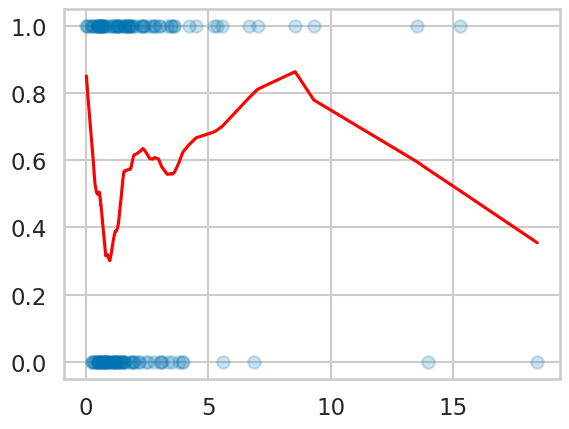

In [ ]:
lowess = sm.nonparametric.lowess
x = SRS['SIRI']
y = SRS['death12']
z = lowess(y, x, frac=0.3)
plt.scatter(x, y, alpha=0.2)
plt.plot(z[:,0], z[:,1], color='red')

In [ ]:
SRS.death6.value_counts()

,count
death6,
0,97
1,44


In [ ]:
SRS[SRS.death == 0].OS_mos.min()

27

In [ ]:
SRS.n_mets.sum(axis=0)

np.int64(216)

In [ ]:
category(SRS, "fx").round(2)

,count,proportion
fx,,
1,76,0.54
3,32,0.23
5,32,0.23
8,1,0.01


In [ ]:
"""for i in ["PFS_mos", "OS_mos"]:
  normality_check(SRS[i])

print(SRS.death.value_counts(normalize=False))
print(SRS.death.value_counts(normalize=True))"""

"""for i in ["NLR", "PLR", "LMR", "SII", "SIRI"]:
  for j in ["death1", "death3", "death6", "death12", "death24"]:
    compare_continuous_by_group(SRS, i, group_col=j)"""

pd.crosstab(SRS["origin"], SRS["death6"])

death6,0,1
origin,,
0,56,16
1,12,4
2,11,7
4,18,17


# logistic (univariate)

In [ ]:
dataframe = SRS.copy()
features = ["age", "male", "n_mets", "BG", "pfossa",
            "origin_0", "origin_1", "origin_2", "origin_4",
            "n_ca",
            "NLR", "PLR", "LMR", "SII/100", "SIRI",
            "fx"]
outcome = "death12"

results = []

for feature in features:
    df_sub = dataframe[[outcome, feature]].dropna()
    X = sm.add_constant(df_sub[feature])
    y = df_sub[outcome]

    model = sm.Logit(y, X).fit(disp=0)
    coef = model.params[feature]
    se = model.bse[feature]
    OR = np.exp(coef).round(2)
    lower = np.exp(coef - 1.96 * se).round(2)
    upper = np.exp(coef + 1.96 * se).round(2)
    pval = model.pvalues[feature].round(2)

    results.append({
        "variable": feature,
        "OR": OR,
        "lower95%": lower,
        "upper95%": upper,
        "p": pval
    })

univ_logit = pd.DataFrame(results)
print(univ_logit)

    variable    OR  lower95%  upper95%     p
0        age  0.99      0.96      1.02  0.51
1       male  1.27      0.65      2.47  0.48
2     n_mets  1.23      0.81      1.86  0.33
3         BG  1.83      0.16     20.69  0.62
4     pfossa  1.70      0.76      3.81  0.20
5   origin_0  0.51      0.26      1.01  0.05
6   origin_1  0.89      0.32      2.53  0.83
7   origin_2  1.15      0.43      3.12  0.78
8   origin_4  2.44      1.09      5.49  0.03
9       n_ca  0.53      0.17      1.72  0.29
10       NLR  1.08      0.99      1.19  0.09
11       PLR  1.00      1.00      1.01  0.07
12       LMR  1.06      0.96      1.16  0.27
13   SII/100  1.03      1.00      1.06  0.07
14      SIRI  1.05      0.93      1.19  0.41
15        fx  1.02      0.84      1.23  0.88


Correlation coef

  NLR associate with PLR, SII, SIRI

  PLR: SII

  SII: SIRI

In [ ]:
features = ["age", "male", "n_mets", "BG", "pfossa",
            "origin_0", "origin_1", "origin_2", "origin_4",
            "n_ca",
            "NLR", "PLR", "LMR", "SII", "SIRI",
            "fx"]

outcome = "death1"

df = SRS.copy()

# Select predictors and outcome
X = df[features]
y = df[outcome]

# Add constant for statsmodels
X_const = sm.add_constant(X)

# Ensure all columns are numeric float
X_const = X_const.astype(float)

# Compute correlation matrix
corr = X.corr().abs()

corr

,age,male,n_mets,BG,pfossa,origin_0,origin_1,origin_2,origin_4,n_ca,NLR,PLR,LMR,SII,SIRI,fx
age,1.000000,0.190424,0.086896,0.037269,0.135080,0.166614,0.274096,0.102336,0.070611,0.157883,0.037346,0.125085,0.003558,0.033980,0.032444,0.100852
male,0.190424,1.000000,0.008685,0.164058,0.010145,0.119006,0.398091,0.172810,0.021078,0.187793,0.063089,0.038726,0.108871,0.073223,0.108907,0.016056
n_mets,0.086896,0.008685,1.000000,0.085858,0.083809,0.100642,0.069248,0.147384,0.053451,0.058399,0.027778,0.138303,0.111195,0.036260,0.077063,0.548928
BG,0.037269,0.164058,0.085858,1.000000,0.079888,0.144338,0.052750,0.056403,0.084723,0.046988,0.012540,0.030375,0.002565,0.016274,0.046393,0.064535
pfossa,0.135080,0.010145,0.083809,0.079888,1.000000,0.113147,0.126457,0.046421,0.002224,0.002906,0.150365,0.026193,0.182803,0.139813,0.149076,0.028233
origin_0,0.166614,0.119006,0.100642,0.144338,0.113147,1.000000,0.365466,0.390774,0.586979,0.066778,0.198706,0.179891,0.040444,0.147471,0.101262,0.163586
origin_1,0.274096,0.398091,0.069248,0.052750,0.126457,0.365466,1.000000,0.136864,0.205582,0.114018,0.017631,0.004680,0.123327,0.078621,0.030115,0.020786
origin_2,0.102336,0.172810,0.147384,0.056403,0.046421,0.390774,0.136864,1.000000,0.219819,0.025008,0.099092,0.025836,0.098865,0.080668,0.118355,0.207306
origin_4,0.070611,0.021078,0.053451,0.084723,0.002224,0.586979,0.205582,0.219819,1.000000,0.012879,0.166336,0.191646,0.060977,0.166061,0.003638,0.044416
n_ca,0.157883,0.187793,0.058399,0.046988,0.002906,0.066778,0.114018,0.025008,0.012879,1.000000,0.091486,0.132481,0.070284,0.088757,0.048975,0.052628


In [ ]:
# VIF

features = ["age", "male", "n_mets", "BG", "pfossa",
            #"origin_0", "origin_1", "origin_2", "origin_4",
            "n_ca",
            "SIRI",
            "fx"]

X = sm.add_constant(SRS[features])  # include intercept

# Create VIF dataframe
vif_df = pd.DataFrame()
vif_df["feature"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_df)

     feature       VIF
0      const  0.000000
1        age  1.165825
2       male  1.326174
3     n_mets  1.480019
4         BG  1.076992
5     pfossa  1.090418
6   origin_0       inf
7   origin_1       inf
8   origin_2       inf
9   origin_4       inf
10      n_ca  1.068945
11      SIRI  1.078085
12        fx  1.494958


/usr/local/lib/python3.12/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.12/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


     feature        VIF
0      const  68.457533
1        age   1.167500
2       male   1.308885
3     n_mets   1.481233
4         BG   1.076732
5     pfossa   1.086231
6       n_ca   1.073288
7        SII   1.088652
8         fx   1.494822
9   origin_1   1.400556
10  origin_2   1.196163
11  origin_4   1.199135
Optimization terminated successfully.
         Current function value: 0.534496
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 death6   No. Observations:                  141
Model:                          Logit   Df Residuals:                      129
Method:                           MLE   Df Model:                           11
Date:                Wed, 10 Sep 2025   Pseudo R-squ.:                  0.1389
Time:                        03:34:35   Log-Likelihood:                -75.364
converged:                       True   LL-Null:                       -87.524
Covariance Type:            nonro

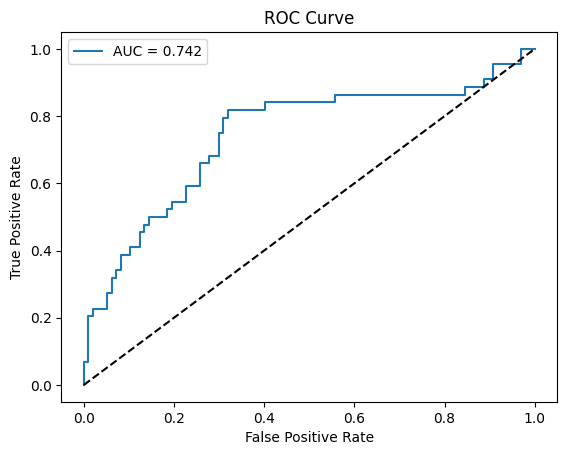

In [ ]:
# Logistic regression
logit_model = sm.Logit(y, X_const).fit()
print(logit_model.summary())

# metrics
y_pred_prob = logit_model.predict(X_const)
y_pred = (y_pred_prob >= 0.5).astype(int)
print("Accuracy:", accuracy_score(y, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y, y_pred))
print("Classification Report:\n", classification_report(y, y_pred, digits=3))

# --- ROC curve ---
fpr, tpr, _ = roc_curve(y, y_pred_prob)
roc_auc = roc_auc_score(y, y_pred_prob)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# logistic (multivariable, backward elimination)

Dropping age (p=0.654)
Dropping origin_2 (p=1.000)
Dropping origin_1 (p=0.874)
Dropping const (p=0.765)
Dropping fx (p=0.663)
Dropping origin_0 (p=0.406)
Dropping BG (p=0.411)
Dropping male (p=0.452)
Dropping SIRI (p=0.294)
Dropping n_mets (p=0.255)
Dropping n_ca (p=0.173)
Dropping pfossa (p=0.355)
                           Logit Regression Results                           
Dep. Variable:                death12   No. Observations:                  141
Model:                          Logit   Df Residuals:                      140
Method:                           MLE   Df Model:                            0
Date:                Sat, 18 Oct 2025   Pseudo R-squ.:                 0.02357
Time:                        17:28:46   Log-Likelihood:                -95.261
converged:                       True   LL-Null:                       -97.560
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025  

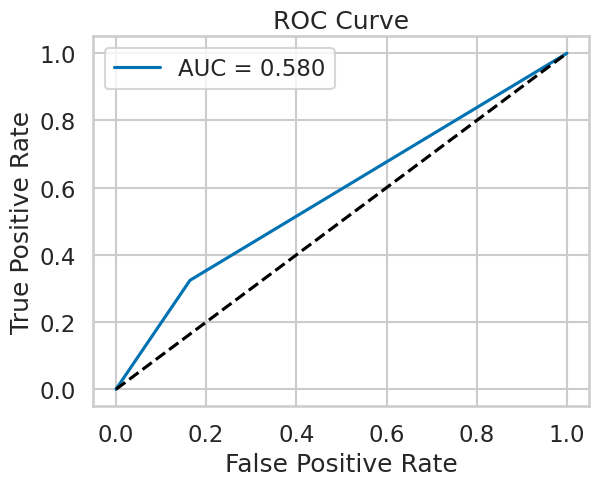

In [ ]:
logit_model, X_selected = LR_stepwise(SRS,
 ["age", "male", "n_mets",
  "BG",
  "pfossa",
  "SIRI",
  "n_ca",
  "origin", "fx"],
                                      "death12")

## ROC of all

In [ ]:
def LR_stepwise(SRS, features, outcome):
    """Multivariable logistic regression using stepwise backward elimination"""
    df = SRS[features + [outcome]].copy()
    if "origin" in df.columns:
        df["origin"] = df["origin"].astype("category")
        df = pd.get_dummies(df, columns=["origin"], drop_first=True)

    X = df.drop(columns=[outcome])
    y = df[outcome]

    X_const = sm.add_constant(X).astype(float)

    X_selected, logit_model = stepwise_selection(X_const, y)
    y_pred_prob = logit_model.predict(X_selected)

    fpr, tpr, _ = roc_curve(y, y_pred_prob)
    auc_value = roc_auc_score(y, y_pred_prob)

    return logit_model, X_selected, fpr, tpr, auc_value

Dropping origin_1 (p=0.924)
Dropping fx (p=0.877)
Dropping age (p=0.779)
Dropping male (p=0.707)
Dropping origin_4 (p=0.477)
Dropping n_mets (p=0.465)
Dropping pfossa (p=0.417)
Dropping origin_2 (p=0.277)
Dropping male (p=0.852)
Dropping fx (p=0.853)
Dropping age (p=0.575)
Dropping n_mets (p=0.527)
Dropping origin_1 (p=0.532)
Dropping pfossa (p=0.489)
Dropping origin_2 (p=0.190)
Dropping origin_4 (p=0.283)
Dropping fx (p=0.942)
Dropping origin_1 (p=0.791)
Dropping age (p=0.619)
Dropping male (p=0.644)
Dropping n_mets (p=0.448)
Dropping pfossa (p=0.355)
Dropping origin_4 (p=0.327)
Dropping origin_2 (p=0.237)
Dropping origin_1 (p=0.995)
Dropping age (p=0.943)
Dropping fx (p=0.729)
Dropping origin_4 (p=0.538)
Dropping male (p=0.423)
Dropping n_mets (p=0.271)
Dropping pfossa (p=0.256)
Dropping origin_2 (p=0.175)
Dropping origin_1 (p=0.921)
Dropping fx (p=0.899)
Dropping age (p=0.753)
Dropping male (p=0.487)
Dropping n_mets (p=0.437)
Dropping pfossa (p=0.150)
Dropping LMR (p=0.247)
Dropping

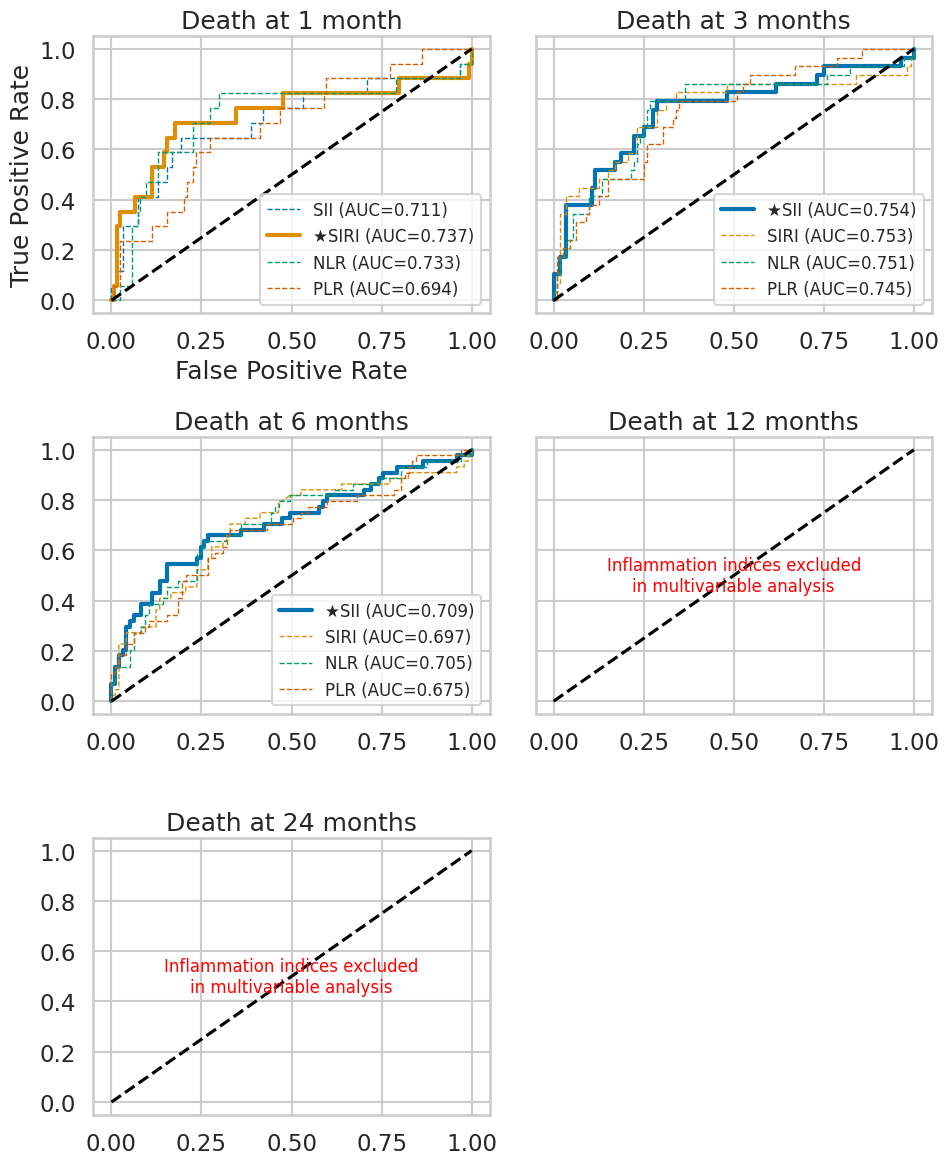

In [ ]:
outcomes = ["death1", "death3", "death6", "death12", "death24"]
biomarkers = ["SII", "SIRI", "NLR", "PLR", "LMR"]

titles = {
    "death1": "Death at 1 month",
    "death3": "Death at 3 months",
    "death6": "Death at 6 months",
    "death12": "Death at 12 months",
    "death24": "Death at 24 months"
}

n_rows = 3
n_cols = 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 12), sharey=True, sharex=False)
axes = axes.flatten()  # Flatten for easy indexing

for i, outcome in enumerate(outcomes):
    ax = axes[i]
    results = []
    for biomarker in biomarkers:
        features = ["age", "male", "n_mets", "pfossa", biomarker, "origin", "fx"]

        # Run stepwise logistic regression
        logit_model, X_selected, fpr, tpr, auc_value = LR_stepwise(SRS, features, outcome)

        # Include only biomarkers retained in final model
        if biomarker in X_selected.columns:
            results.append((biomarker, fpr, tpr, auc_value))

    ax.set_title(titles.get(outcome, f"ROC Curves for {outcome}"))
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")

    if i > 0:
      ax.set_xlabel("")
      ax.set_ylabel("")

    if results:  # If any biomarker retained
        best = max(results, key=lambda x: x[3])
        for biomarker, fpr, tpr, auc_value in results:
            if biomarker == best[0]:
                ax.plot(fpr, tpr, linewidth=3, label=f"★{biomarker} (AUC={auc_value:.3f})")
            else:
                ax.plot(fpr, tpr, linewidth=1, linestyle="--", label=f"{biomarker} (AUC={auc_value:.3f})")
        ax.plot([0, 1], [0, 1], "k--")
        ax.legend(fontsize=12)
    else:  # Message instead of ROC
        ax.text(0.5, 0.5, "Inflammation indices excluded\nin multivariable analysis",
                horizontalalignment='center', verticalalignment='center',
                fontsize=12, color='red')
        ax.plot([0, 1], [0, 1], "k--")  # Optional diagonal line for reference

# Hide any extra subplot if total slots > number of outcomes
if len(outcomes) < n_rows * n_cols:
    for j in range(len(outcomes), n_rows * n_cols):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## AUC lineplot

In [ ]:
outcomes = ["death1", "death3", "death6", "death12", "death24"]
biomarkers = ["SII", "SIRI", "NLR", "PLR", "LMR"]

auc_summary = []

n_boot = 1000  # bootstrap iterations for 95% CI

for outcome in outcomes:
    best_auc = 0
    best_biomarker = None
    y_true = SRS[outcome]

    for biomarker in biomarkers:
        features = ["age", "male", "n_mets", "pfossa", biomarker, "origin", "fx"]
        logit_model, X_selected, _, _, auc_value = LR_stepwise(SRS, features, outcome)

        if biomarker in X_selected.columns and auc_value > best_auc:
            best_auc = auc_value
            best_biomarker = biomarker
            X_best = X_selected
            y_pred_prob = logit_model.predict(X_best)

    if best_biomarker is not None:
        # bootstrap to get 95% CI
        boot_aucs = []
        for _ in range(n_boot):
            indices = resample(range(len(y_true)))
            boot_auc = roc_auc_score(y_true.iloc[indices], y_pred_prob.iloc[indices])
            boot_aucs.append(boot_auc)
        lower = np.percentile(boot_aucs, 2.5)
        upper = np.percentile(boot_aucs, 97.5)

        auc_summary.append({
            "outcome": outcome,
            "best_biomarker": best_biomarker,
            "AUC": best_auc,
            "lower95": lower,
            "upper95": upper
        })
    else:
        # No biomarker retained
        auc_summary.append({
            "outcome": outcome,
            "best_biomarker": None,
            "AUC": np.nan,
            "lower95": np.nan,
            "upper95": np.nan
        })

df_auc = pd.DataFrame(auc_summary)
print(df_auc)

Dropping origin_1 (p=0.924)
Dropping fx (p=0.877)
Dropping age (p=0.779)
Dropping male (p=0.707)
Dropping origin_4 (p=0.477)
Dropping n_mets (p=0.465)
Dropping pfossa (p=0.417)
Dropping origin_2 (p=0.277)
Dropping male (p=0.852)
Dropping fx (p=0.853)
Dropping age (p=0.575)
Dropping n_mets (p=0.527)
Dropping origin_1 (p=0.532)
Dropping pfossa (p=0.489)
Dropping origin_2 (p=0.190)
Dropping origin_4 (p=0.283)
Dropping fx (p=0.942)
Dropping origin_1 (p=0.791)
Dropping age (p=0.619)
Dropping male (p=0.644)
Dropping n_mets (p=0.448)
Dropping pfossa (p=0.355)
Dropping origin_4 (p=0.327)
Dropping origin_2 (p=0.237)
Dropping origin_1 (p=0.995)
Dropping age (p=0.943)
Dropping fx (p=0.729)
Dropping origin_4 (p=0.538)
Dropping male (p=0.423)
Dropping n_mets (p=0.271)
Dropping pfossa (p=0.256)
Dropping origin_2 (p=0.175)
Dropping origin_1 (p=0.921)
Dropping fx (p=0.899)
Dropping age (p=0.753)
Dropping male (p=0.487)
Dropping n_mets (p=0.437)
Dropping pfossa (p=0.150)
Dropping LMR (p=0.247)
Dropping

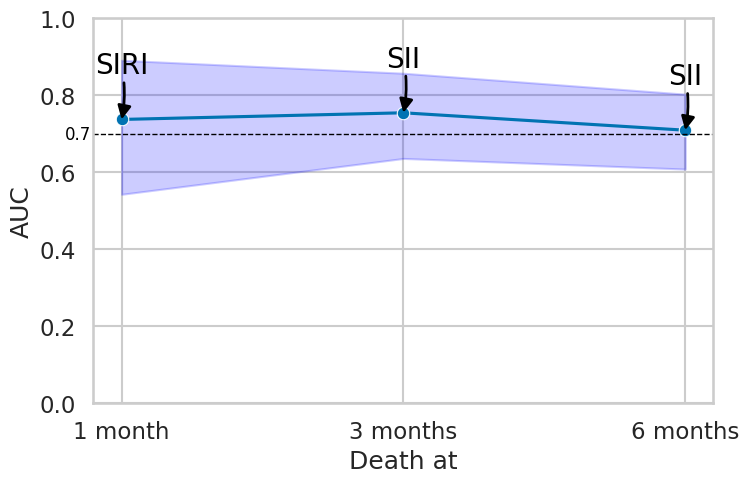

In [ ]:
plt.figure(figsize=(8, 5))

# Line plot for best AUC
sns.lineplot(
    data=df_auc,
    x="outcome",
    y="AUC",
    marker="o",
    label=None
)

# Shaded 95% CI
plt.fill_between(
    x=df_auc["outcome"],
    y1=df_auc["lower95"],
    y2=df_auc["upper95"],
    color="blue",
    alpha=0.2
)

# Horizontal line at y=0.7
plt.axhline(y=0.7, color="black", linestyle="--", linewidth=1)

# Annotation for 0.7 on y-axis
plt.text(
    x=-0.2,    # slightly left of first outcome
    y=0.7,
    s="0.7",
    color="black",
    fontsize=12,
    verticalalignment="center"
)

plt.ylim(0.0, 1.0)
plt.xlabel("Death at")
plt.xticks(
    ticks=range(len(df_auc["outcome"]) - 2),
    labels=["1 month", "3 months", "6 months"],
    rotation=0
)
plt.ylabel("AUC")
plt.title(None)
plt.grid(True)

# --- Add arrows and text labels ---
annotations = {
    0: "SIRI",   # x-index for 1 month
    1: "SII",    # x-index for 3 months
    2: "SII"     # x-index for 6 months
}

for i, label in annotations.items():
    if i < len(df_auc):
        plt.annotate(
          label,
          xy=(i, df_auc.loc[i, "AUC"]),            # arrow tip
          xytext=(i, df_auc.loc[i, "AUC"] + 0.12), # move text higher above point
          arrowprops=dict(
              arrowstyle="-|>",        # longer, more visible arrowhead
              color="black",
              lw=2,
              shrinkA=0, shrinkB=0,    # prevents shortening near text and point
              connectionstyle="arc3,rad=-0.1"  # slight curve looks better
          ),
          ha="center",
          fontsize=20,
          color="black"
      )

plt.show()

In [ ]:
def predict_death(SII, origin_4, model, threshold=best_thresh):
    logit = model.params["const"] + model.params["SII"]*SII + model.params["origin_4"]*origin_4
    p = 1 / (1 + np.exp(-logit))
    y_pred = int(p >= threshold)
    return p, y_pred

NameError: name 'best_thresh' is not defined

In [ ]:
predict_death6(500, 1, logit_model)

NameError: name 'predict_death6' is not defined

Dropping n_mets (p=0.772)
Dropping pfossa (p=0.643)
Dropping n_ca (p=0.617)
Dropping male (p=0.581)
Dropping origin_1 (p=0.621)
Dropping BG (p=0.600)
Dropping origin_2 (p=0.608)
Dropping age (p=0.527)
Dropping fx (p=0.101)
                           Logit Regression Results                           
Dep. Variable:                 death6   No. Observations:                  141
Model:                          Logit   Df Residuals:                      138
Method:                           MLE   Df Model:                            2
Date:                Wed, 10 Sep 2025   Pseudo R-squ.:                  0.1120
Time:                        14:28:18   Log-Likelihood:                -77.724
converged:                       True   LL-Null:                       -87.524
Covariance Type:            nonrobust   LLR p-value:                 5.547e-05
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------

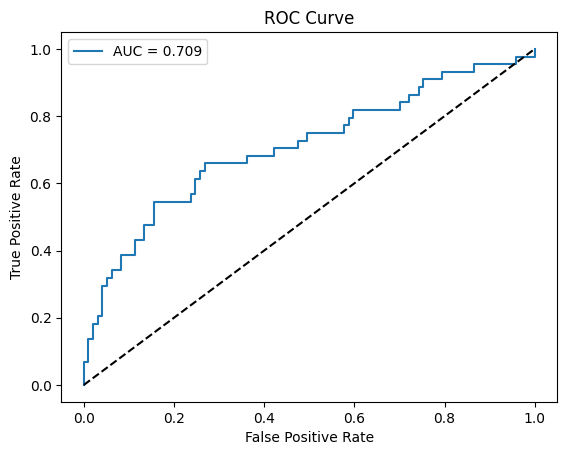

Best threshold (ROC / Youden’s J): 0.3131849978292248
Best threshold (PR / F1 score): 0.3131849978292248

--- Metrics at ROC/Youden threshold (0.31) ---
Accuracy: 0.7092198581560284
Confusion Matrix:
 [[71 26]
 [15 29]]
Classification Report:
               precision    recall  f1-score   support

           0      0.826     0.732     0.776        97
           1      0.527     0.659     0.586        44

    accuracy                          0.709       141
   macro avg      0.676     0.696     0.681       141
weighted avg      0.732     0.709     0.717       141


--- Metrics at PR/F1 threshold (0.31) ---
Accuracy: 0.7092198581560284
Confusion Matrix:
 [[71 26]
 [15 29]]
Classification Report:
               precision    recall  f1-score   support

           0      0.826     0.732     0.776        97
           1      0.527     0.659     0.586        44

    accuracy                          0.709       141
   macro avg      0.676     0.696     0.681       141
weighted avg      0.732

In [ ]:
## Logistic regression, feature selection, and eval ##

X_selected, logit_model = stepwise_selection(X_const, y)
print(logit_model.summary())

# --- Predictions ---
y_pred_prob = logit_model.predict(X_selected)
y_pred = (y_pred_prob >= 0.5).astype(int)

# --- ROC curve ---
fpr, tpr, _ = roc_curve(y, y_pred_prob)
roc_auc = roc_auc_score(y, y_pred_prob)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

"""# --- Precision-Recall curve ---
prec, rec, _ = precision_recall_curve(y, y_pred_prob)
plt.plot(rec, prec, label=f"AUC = {auc(rec, prec):.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()"""

# Predicted probabilities
y_pred_prob = logit_model.predict(X_selected)

### 1. Best threshold by Youden’s J (ROC)
fpr, tpr, thresholds_roc = roc_curve(y, y_pred_prob)
youden_j = tpr - fpr
best_thresh_roc = thresholds_roc[np.argmax(youden_j)]
print("Best threshold (ROC / Youden’s J):", best_thresh_roc)

### 2. Best threshold by F1 score (PR)
precisions, recalls, thresholds_pr = precision_recall_curve(y, y_pred_prob)

f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
best_thresh_pr = thresholds_pr[np.argmax(f1_scores[:-1])]  # last precision/recall has no threshold
print("Best threshold (PR / F1 score):", best_thresh_pr)

### 3. Evaluate at both thresholds
for label, thresh in [("ROC/Youden", best_thresh_roc), ("PR/F1", best_thresh_pr)]:
    y_pred_adj = (y_pred_prob >= thresh).astype(int)
    print(f"\n--- Metrics at {label} threshold ({thresh:.2f}) ---")
    print("Accuracy:", accuracy_score(y, y_pred_adj))
    print("Confusion Matrix:\n", confusion_matrix(y, y_pred_adj))
    print("Classification Report:\n", classification_report(y, y_pred_adj, digits=3))

In [ ]:
## Random forest ##

# -------------------------
# Define features and outcome
# -------------------------
df = SRS.copy()
features = ["age", "male", "n_mets",
            "BG", "pfossa",
            "n_ca", "NLR", "PLR", "LMR", "SII", "SIRI",
            "origin", "fx"]
outcome = "death6"

# One-hot encode categorical variables (if needed)
df_encoded = pd.get_dummies(df, columns=["origin"], drop_first=True)

# Update feature list to include the new dummies (if any)
feature_cols = [col for col in df_encoded.columns if col in features or col.startswith("origin_")]

X = df_encoded[feature_cols]
y = df_encoded[outcome]

# -------------------------
# Train/test split
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# -------------------------
# Random Forest
# -------------------------
rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    random_state=42,
    class_weight="balanced"   # useful if data is imbalanced
)
rf.fit(X_train, y_train)

# -------------------------
# Predictions and metrics
# -------------------------
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, digits=3)

print("Accuracy:", round(acc, 3))
print("ROC-AUC:", round(auc, 3))
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", report)

# -------------------------
# Feature Importance
# -------------------------
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nFeature Importances:\n", importances)

Accuracy: 0.651
ROC-AUC: 0.64

Confusion Matrix:
 [[25  5]
 [10  3]]

Classification Report:
               precision    recall  f1-score   support

           0      0.714     0.833     0.769        30
           1      0.375     0.231     0.286        13

    accuracy                          0.651        43
   macro avg      0.545     0.532     0.527        43
weighted avg      0.612     0.651     0.623        43


Feature Importances:
 SIRI        0.164834
LMR         0.161083
NLR         0.150978
SII         0.144990
PLR         0.115444
age         0.082486
fx          0.038159
origin_4    0.035211
n_ca        0.026361
origin_1    0.021253
male        0.018922
n_mets      0.017600
pfossa      0.014951
origin_2    0.006617
BG          0.001110
dtype: float64


3 models:
 logistic regression
 random forest
 XG boost

9/7) LR is better than RF or XGboost, may need to fine tune RF/ XG

In [ ]:
### Compare 3 models (LR, RF, XGboost) ###

# ---- Data prep (your part stays the same) ----
features = ["age", "male", "n_mets", "BG", "pfossa",
            "n_ca", "SII", "origin", "fx", "death6"]
outcome = "death6"

df = SRS[features].copy()
df["origin"] = df["origin"].astype("category")
df_encoded = pd.get_dummies(df, columns=["origin"], drop_first=True)

X = df_encoded.drop(columns=[outcome])
y = df_encoded[outcome]

# ---- Models ----
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, solver="liblinear"),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost": XGBClassifier(
        n_estimators=200, learning_rate=0.05, max_depth=3,
        subsample=0.8, colsample_bytree=0.8,
        eval_metric="logloss", use_label_encoder=False, random_state=42
    )
}

# ---- Metrics ----
scoring = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "f1": "f1",
    "roc_auc": "roc_auc",   # use string, built-in scorer
    "pr_auc": make_scorer(average_precision_score, response_method="predict_proba")
}

# ---- Cross-validation ----
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = {}
for name, model in models.items():
    cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring, return_train_score=False)
    results[name] = {metric: np.mean(scores) for metric, scores in cv_results.items() if "test" in metric}

# ---- Display results ----
results_df = pd.DataFrame(results).T
print(results_df)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [00:42:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [00:42:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [00:42:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [00:42:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


                     test_accuracy  test_precision  test_recall   test_f1  \
Logistic Regression       0.716502        0.653333     0.269444  0.353189   
Random Forest             0.666995        0.470909     0.336111  0.367241   
XGBoost                   0.659852        0.468889     0.294444  0.333273   

                     test_roc_auc  test_pr_auc  
Logistic Regression      0.660234     0.566204  
Random Forest            0.628289     0.504554  
XGBoost                  0.621791     0.489607  


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [00:42:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
X = SRS[["age", 'male', 'origin', "NLR", "PLR", "LMR", "SII", "SIRI"]]
y = Surv.from_dataframe(event='death', time='OS_mos', data=SRS)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize random survival forest (RSF)
rsf = RandomSurvivalForest(
    n_estimators=100,
    min_samples_split=10,
    min_samples_leaf=15,
    max_features="sqrt",
    n_jobs=-1,
    random_state=42
)

rsf.fit(X_train, y_train)

# Evaluate: Concordance index
cindex = concordance_index_censored(
    y_test['death'], y_test['OS_mos'], rsf.predict(X_test)
)[0]

print(f"Concordance Index: {cindex:.3f}")

Concordance Index: 0.608


In [ ]:
from sklearn.model_selection import ParameterSampler, KFold
import numpy as np
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored

param_dist = {
    'n_estimators': [50, 100, 200],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10],
    'max_features': ['sqrt', 'log2', None]
}

n_iter = 20
random_state = 42
params_list = list(ParameterSampler(param_dist, n_iter=n_iter, random_state=random_state))

kf = KFold(n_splits=3, shuffle=True, random_state=random_state)

best_score = -np.inf
best_params = None

for params in params_list:
    scores = []
    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        model = RandomSurvivalForest(random_state=42, n_jobs=-1, **params)
        model.fit(X_tr, y_tr)

        pred = model.predict(X_val)
        cindex = concordance_index_censored(y_val["death"], y_val["OS_mos"], pred)[0]
        scores.append(cindex)

    mean_score = np.mean(scores)
    if mean_score > best_score:
        best_score = mean_score
        best_params = params

print("Best params:", best_params)
print("Best CV concordance index:", best_score)

Best params: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': 'sqrt'}
Best CV concordance index: 0.6417103802323928


# restricted cubic splines

In [ ]:
# Predictor, outcome, and covariates
x = SRS["SIRI"]
y = SRS["death"]
"""covariates = SRS[["origin_4"]]"""

# Knots at 10th, 50th, 90th percentiles
knots = np.percentile(x, [10, 50, 90])

# Restricted cubic spline for SII
rcs = dmatrix("bs(x, knots=knots, degree=3, include_intercept=False)", {"x": x}, return_type="dataframe")

"""knots = np.percentile(x.dropna(), [25, 75])   # try 2 knots at 25th & 75th pct
rcs = dmatrix("bs(x, knots=knots, degree=3, include_intercept=False)",
              {"x": x, "knots": knots}, return_type="dataframe")"""

# Combine spline terms + covariates
X = pd.concat([covariates, rcs], axis=1)
X = sm.add_constant(X)

# Fit logistic regression
model = sm.Logit(y, X).fit()
print(model.summary())

# Predict adjusted OR across SII range
x_pred = np.linspace(x.quantile(0.01), x.quantile(0.99), 200)
X_pred_rcs = dmatrix("bs(x, knots=knots, degree=3, include_intercept=False)", {"x": x_pred, "knots": knots}, return_type="dataframe")
X_pred = pd.concat([pd.DataFrame(np.repeat(covariates.mean().values.reshape(1, -1), 200, axis=0), columns=covariates.columns),
                    X_pred_rcs], axis=1)
X_pred = sm.add_constant(X_pred)
log_odds = model.predict(X_pred, linear=True)

# Convert to OR relative to median SII — stable approach
ref = np.median(x)

# Build reference spline using same formula and same 'knots' (use name "x")
ref_rcs = dmatrix(rcs.design_info, {"x": [ref]}, return_type="dataframe")

# Build X_ref (use covariates mean as before)
X_ref = pd.concat([covariates.mean().to_frame().T.reset_index(drop=True), ref_rcs.reset_index(drop=True)], axis=1)
X_ref = sm.add_constant(X_ref)
ref_logodds = model.predict(X_ref, linear=True)[0]

OR = np.exp(log_odds - ref_logodds)

# Plot OR vs SII
plt.figure(figsize=(6,4))
plt.plot(x_pred, OR, color="red", linewidth=2)
plt.axhline(1, color="black", linestyle="--")
plt.xlabel(x.name)
plt.title("Restricted cubic spline: SII vs death6")
plt.show()

Optimization terminated successfully.
         Current function value: 0.436822
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  death   No. Observations:                  141
Model:                          Logit   Df Residuals:                      134
Method:                           MLE   Df Model:                            6
Date:                Fri, 17 Oct 2025   Pseudo R-squ.:                 0.06519
Time:                        03:54:09   Log-Likelihood:                -61.592
converged:                       True   LL-Null:                       -65.887
Covariance Type:            nonrobust   LLR p-value:                    0.1980
                                                               coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------
Intercept       

AttributeError: 'NoneType' object has no attribute 'mean'

Optimization terminated successfully.
         Current function value: 0.436822
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  death   No. Observations:                  141
Model:                          Logit   Df Residuals:                      134
Method:                           MLE   Df Model:                            6
Date:                Fri, 17 Oct 2025   Pseudo R-squ.:                 0.06519
Time:                        03:56:58   Log-Likelihood:                -61.592
converged:                       True   LL-Null:                       -65.887
Covariance Type:            nonrobust   LLR p-value:                    0.1980
                                                               coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------
Intercept       

/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:530: FutureWarning: linear keyword is deprecated, use which="linear"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:530: FutureWarning: linear keyword is deprecated, use which="linear"
  warnings.warn(msg, FutureWarning)


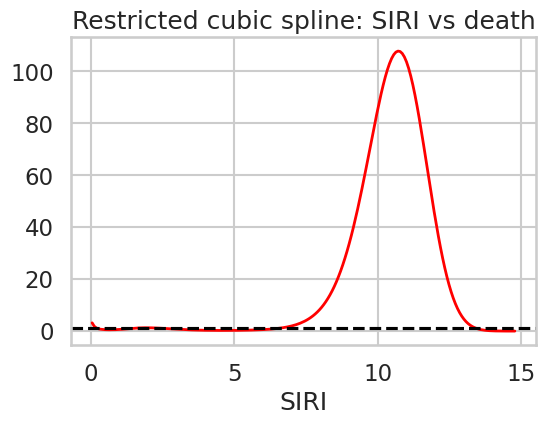

In [ ]:
# no covariates

# Predictor and outcome
x = SRS["SIRI"]
y = SRS["death"]

# Knots at 10th, 50th, 90th percentiles
knots = np.percentile(x, [10, 50, 90])

# Restricted cubic spline for SIRI
rcs = dmatrix("bs(x, knots=knots, degree=3, include_intercept=False)",
              {"x": x}, return_type="dataframe")

# Combine spline terms only
X = sm.add_constant(rcs)

# Fit logistic regression
model = sm.Logit(y, X).fit()
print(model.summary())

# Predict adjusted OR across SIRI range
x_pred = np.linspace(x.quantile(0.01), x.quantile(0.99), 200)
X_pred_rcs = dmatrix("bs(x, knots=knots, degree=3, include_intercept=False)",
                     {"x": x_pred, "knots": knots}, return_type="dataframe")
X_pred = sm.add_constant(X_pred_rcs)
log_odds = model.predict(X_pred, linear=True)

# Reference at median SIRI
ref = np.median(x)
ref_rcs = dmatrix(rcs.design_info, {"x": [ref]}, return_type="dataframe")
X_ref = sm.add_constant(ref_rcs)
ref_logodds = model.predict(X_ref, linear=True)[0]

# OR relative to median
OR = np.exp(log_odds - ref_logodds)

# Plot
plt.figure(figsize=(6,4))
plt.plot(x_pred, OR, color="red", linewidth=2)
plt.axhline(1, color="black", linestyle="--")
plt.xlabel(x.name)
plt.title(f"Restricted cubic spline: {x.name} vs death")
plt.show()

/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:530: FutureWarning: linear keyword is deprecated, use which="linear"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:530: FutureWarning: linear keyword is deprecated, use which="linear"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:530: FutureWarning: linear keyword is deprecated, use which="linear"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:530: FutureWarning: linear keyword is deprecated, use which="linear"
  warnings.warn(msg, FutureWarning)


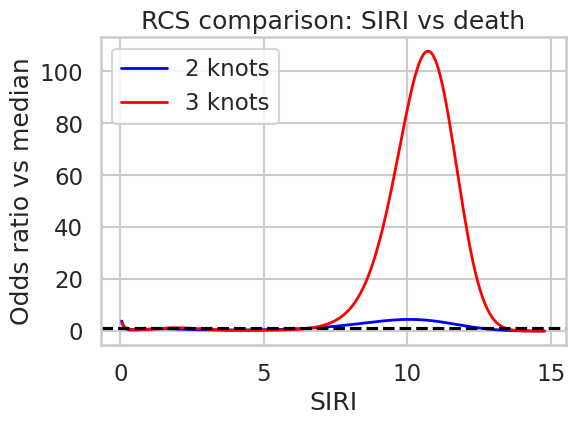

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from patsy import dmatrix
import matplotlib.pyplot as plt

x = SRS["SIRI"]
y = SRS["death"]

plt.figure(figsize=(6,4))

for n_knots, color in zip([2, 3], ["blue", "red"]):
    # Define knots
    if n_knots == 2:
        knots = np.percentile(x, [25, 75])
    else:
        knots = np.percentile(x, [10, 50, 90])

    # Build spline
    rcs = dmatrix("bs(x, knots=knots, degree=3, include_intercept=False)",
                  {"x": x, "knots": knots}, return_type="dataframe")
    X = sm.add_constant(rcs)

    # Fit logistic model
    model = sm.Logit(y, X).fit(disp=False)

    # Predict log odds
    x_pred = np.linspace(x.quantile(0.01), x.quantile(0.99), 200)
    X_pred_rcs = dmatrix("bs(x, knots=knots, degree=3, include_intercept=False)",
                         {"x": x_pred, "knots": knots}, return_type="dataframe")
    X_pred = sm.add_constant(X_pred_rcs)
    log_odds = model.predict(X_pred, linear=True)

    # Reference at median
    ref = np.median(x)
    ref_rcs = dmatrix(rcs.design_info, {"x": [ref]}, return_type="dataframe")
    X_ref = sm.add_constant(ref_rcs)
    ref_logodds = model.predict(X_ref, linear=True)[0]

    # Convert to OR
    OR = np.exp(log_odds - ref_logodds)

    plt.plot(x_pred, OR, color=color, linewidth=2, label=f"{n_knots} knots")

plt.axhline(1, color="black", linestyle="--")
plt.xlabel(x.name)
plt.ylabel("Odds ratio vs median")
plt.title(f"RCS comparison: {x.name} vs death")
plt.legend()
plt.show()

# Cross validation

In [ ]:
SRS["origin_4"] = df_encoded.origin_4
SRS.origin_4 = SRS.origin_4.astype(int)

def cv_logistic_model_accuracy(SRS, features, outcome, k=5, random_state=42):
    """
    Stratified k-fold cross-validation for logistic regression using selected features.
    Focused on AUC and accuracy (using best Youden threshold).
    Automatically handles categorical features.
    """
    X = SRS[features].copy().astype(float)
    y = SRS[outcome]

    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=random_state)

    y_true_all = []
    y_prob_all = []

    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Add constant for statsmodels
        X_train_const = sm.add_constant(X_train).astype(float)
        X_test_const = sm.add_constant(X_test).astype(float)

        # Fit logistic regression
        model = sm.Logit(y_train, X_train_const).fit(disp=0)

        # Predict probabilities on test fold
        y_prob = model.predict(X_test_const)

        # Store pooled predictions
        y_true_all.extend(y_test)
        y_prob_all.extend(y_prob)

    y_true_all = np.array(y_true_all)
    y_prob_all = np.array(y_prob_all)

    # Compute ROC for threshold selection
    fpr, tpr, thresholds = roc_curve(y_true_all, y_prob_all)
    roc_auc = roc_auc_score(y_true_all, y_prob_all)

    # Best threshold by Youden J
    J = tpr - fpr
    ix_j = J.argmax()
    best_thresh = thresholds[ix_j]

    # Predictions at best threshold
    y_pred = (y_prob_all >= best_thresh).astype(int)

    # Confusion matrix, classification report, accuracy
    cm = confusion_matrix(y_true_all, y_pred)
    cr = classification_report(y_true_all, y_pred)
    accuracy = (y_pred == y_true_all).mean()

    # Print summary
    print(f"Outcome: {outcome}")
    print(f"AUC: {roc_auc:.3f}")
    print(f"Best threshold (Youden): {best_thresh:.3f}")
    print(f"Accuracy at best threshold: {accuracy:.3f}")
    print("Confusion Matrix:")
    print(cm)
    print("Classification Report:")
    print(cr)

    return {
        "AUC": roc_auc,
        "BestThreshold": best_thresh,
        "Accuracy": accuracy,
        "ConfusionMatrix": cm,
        "ClassificationReport": cr
    }

In [ ]:
# Candidate feature sets per outcome
candidate_features = {
    "death1": [["SII", "n_ca"], ["SIRI", "n_ca"], ["NLR", "n_ca"], ["PLR", "origin_4"]],
    "death3": [["SII", "origin_4"], ["SIRI", "origin_4"], ["NLR", "origin_4"], ["PLR", "origin_4"], ["LMR", "origin_4"]],
    "death6": [["SII", "origin_4"], ["SIRI", "origin_4"], ["NLR", "origin_4"], ["PLR", "origin_4"], ["LMR", "origin_4"]]
}

summary = []
best_models = {}

for outcome, feature_sets in candidate_features.items():
    print(f"\n=== Outcome: {outcome} ===")

    best_acc = -1
    best_result = None
    best_features = None

    for features in feature_sets:
        print(f"Trying features: {features}")
        results = cv_logistic_model_accuracy(SRS, features, outcome, k=5)

        summary.append({
            "Outcome": outcome,
            "Features": ", ".join(features),
            "AUC": results["AUC"],
            "BestThreshold": results["BestThreshold"],
            "Accuracy": results["Accuracy"]
        })

        # Keep track of the best feature set
        if results["Accuracy"] > best_acc:
            best_acc = results["Accuracy"]
            best_result = results
            best_features = features

    # Store best feature set for this outcome
    best_models[outcome] = {"Features": best_features, **best_result}

# Display summary table
summary_df = pd.DataFrame(summary)
print("\n=== All Combinations Summary ===")
print(summary_df)

# Display best models per outcome
best_df = pd.DataFrame([
    {"Outcome": outcome,
     "Features": ", ".join(info["Features"]),
     "AUC": info["AUC"],
     "BestThreshold": info["BestThreshold"],
     "Accuracy": info["Accuracy"]}
    for outcome, info in best_models.items()
])
print("\n=== Best Models per Outcome ===")
print(best_df)


=== Outcome: death1 ===
Trying features: ['SII', 'n_ca']
Outcome: death1
AUC: 0.712
Best threshold (Youden): 0.116
Accuracy at best threshold: 0.759
Confusion Matrix:
[[96 28]
 [ 6 11]]
Classification Report:
              precision    recall  f1-score   support

       False       0.94      0.77      0.85       124
        True       0.28      0.65      0.39        17

    accuracy                           0.76       141
   macro avg       0.61      0.71      0.62       141
weighted avg       0.86      0.76      0.79       141

Trying features: ['SIRI', 'n_ca']
Outcome: death1
AUC: 0.743
Best threshold (Youden): 0.132
Accuracy at best threshold: 0.830
Confusion Matrix:
[[106  18]
 [  6  11]]
Classification Report:
              precision    recall  f1-score   support

       False       0.95      0.85      0.90       124
        True       0.38      0.65      0.48        17

    accuracy                           0.83       141
   macro avg       0.66      0.75      0.69       141
w

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

Outcome: death1
AUC: 0.610
Best threshold (Youden): 0.112
Accuracy at best threshold: 0.667
Confusion Matrix:
[[84 40]
 [ 7 10]]
Classification Report:
              precision    recall  f1-score   support

       False       0.92      0.68      0.78       124
        True       0.20      0.59      0.30        17

    accuracy                           0.67       141
   macro avg       0.56      0.63      0.54       141
weighted avg       0.84      0.67      0.72       141


=== Outcome: death3 ===
Trying features: ['SII', 'origin_4']
Outcome: death3
AUC: 0.747
Best threshold (Youden): 0.184
Accuracy at best threshold: 0.730
Confusion Matrix:
[[80 32]
 [ 6 23]]
Classification Report:
              precision    recall  f1-score   support

       False       0.93      0.71      0.81       112
        True       0.42      0.79      0.55        29

    accuracy                           0.73       141
   macro avg       0.67      0.75      0.68       141
weighted avg       0.82      0.73  

<Axes: xlabel='Outcome', ylabel='Accuracy'>

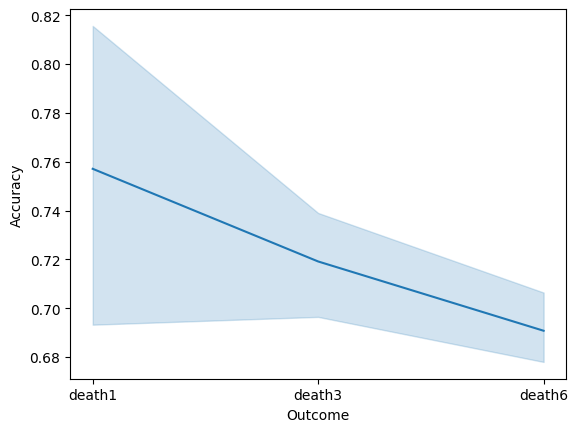

In [ ]:
sns.lineplot(data=summary_df, x="Outcome", y="Accuracy")

# KM curve

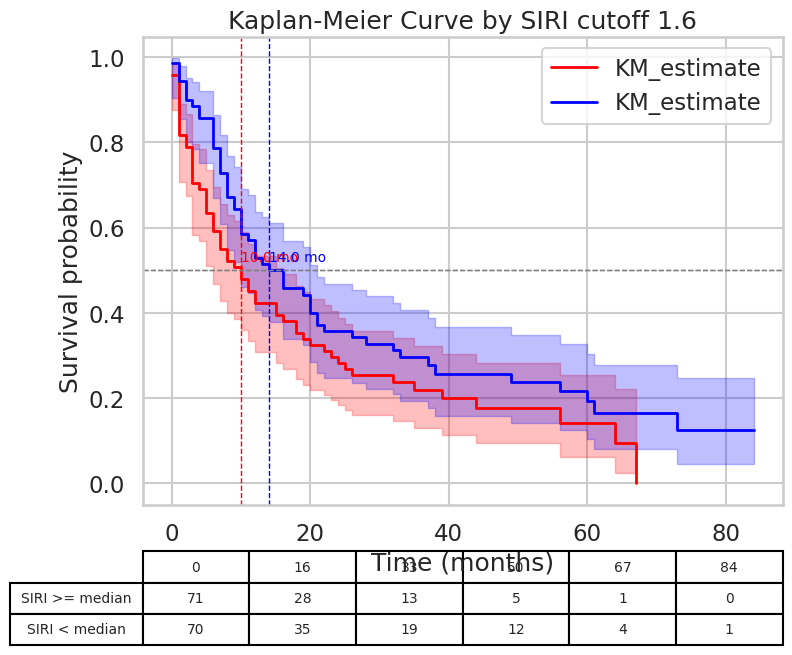

Log-rank test p-value: 0.0846


In [ ]:
# Split groups
group_high = SRS[SRS["SII_median"] == 1]
group_low = SRS[SRS["SII_median"] == 0]

# Kaplan-Meier fitters
kmf_high = KaplanMeierFitter()
kmf_low = KaplanMeierFitter()

kmf_high.fit(durations=group_high["OS_mos"], event_observed=group_high["death"])
kmf_low.fit(durations=group_low["OS_mos"], event_observed=group_low["death"])

# Define time points for number at risk table (5 intervals)
max_time = int(np.ceil(SRS["OS_mos"].max()))
time_points = np.linspace(0, max_time, 6, dtype=int)  # 0, 1/5, 2/5, ..., max_time

# Number at risk function
def num_at_risk(kmf, times):
    return [np.sum(kmf.durations >= t) for t in times]

n_risk_high = num_at_risk(kmf_high, time_points)
n_risk_low = num_at_risk(kmf_low, time_points)

# Plot KM curves
fig, ax = plt.subplots(figsize=(8,6))
kmf_high.plot_survival_function(ax=ax, color='red', lw=2)
kmf_low.plot_survival_function(ax=ax, color='blue', lw=2)

# Median survival lines
for kmf, color in zip([kmf_high, kmf_low], ['red','blue']):
    median = kmf.median_survival_time_
    plt.axhline(0.5, color='gray', linestyle='--', lw=1)
    plt.axvline(median, color=color, linestyle='--', lw=1)
    plt.text(median, 0.52, f"{median:.1f} mo", color=color, fontsize=10)

# Labels
plt.title("Kaplan-Meier Curve by SIRI cutoff 1.6")
plt.xlabel("Time (months)")
plt.ylabel("Survival probability")

# Number at risk table below the plot
cell_text = [
    [str(n) for n in n_risk_high],
    [str(n) for n in n_risk_low]
]
rows = ['SIRI >= median', 'SIRI < median']
cols = [str(t) for t in time_points]

# Add table
the_table = plt.table(cellText=cell_text,
                      rowLabels=rows,
                      colLabels=cols,
                      cellLoc='center',
                      rowLoc='center',
                      colLoc='center',
                      loc='bottom',
                      bbox=[0, -0.3, 1, 0.2])  # [left, bottom, width, height]

the_table.auto_set_font_size(False)
the_table.set_fontsize(10)

# Adjust layout to fit table
plt.subplots_adjust(left=0.1, bottom=0.1)

plt.show()

# Log-rank test
results = logrank_test(group_high["OS_mos"], group_low["OS_mos"],
                       event_observed_A=group_high["death"],
                       event_observed_B=group_low["death"])
print(f"Log-rank test p-value: {results.p_value:.4f}")

## restrictive mean survival time

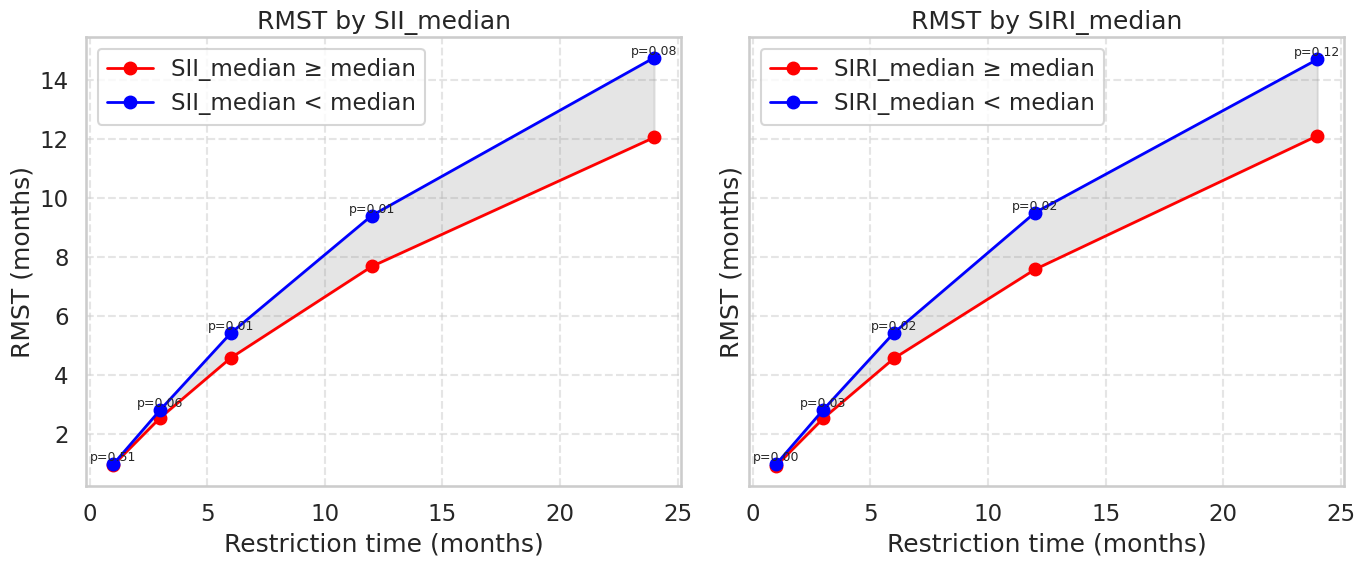

In [ ]:
# --- Parameters ---
time_points = [1, 3, 6, 12, 24]  # months
n_bootstrap = 200  # fast but reasonable; increase if desired
seed = 42

# Define the two grouping variables
group_vars = ["SII_median", "SIRI_median"]

fig, axes = plt.subplots(1, 2, figsize=(14,6), sharey=True)

for ax, group_col_name in zip(axes, group_vars):
    # --- Compute RMST ---
    rmst_high_list = []
    rmst_low_list  = []
    pval_list      = []

    for t in time_points:
        km_high = KaplanMeierFitter().fit(SRS[SRS[group_col_name]==1]["OS_mos"],
                                          SRS[SRS[group_col_name]==1]["death"])
        km_low  = KaplanMeierFitter().fit(SRS[SRS[group_col_name]==0]["OS_mos"],
                                          SRS[SRS[group_col_name]==0]["death"])

        rmst_high = restricted_mean_survival_time(km_high, t)
        rmst_low  = restricted_mean_survival_time(km_low, t)
        rmst_high_list.append(rmst_high)
        rmst_low_list.append(rmst_low)

        _, _, _, p = bootstrap_rmst_diff(SRS, "OS_mos", "death", group_col_name, t, n_bootstrap, seed)
        pval_list.append(p)

    # --- Plot ---
    ax.plot(time_points, rmst_high_list, marker='o', color='red', lw=2, label=f'{group_col_name} ≥ median')
    ax.plot(time_points, rmst_low_list,  marker='o', color='blue', lw=2, label=f'{group_col_name} < median')
    ax.fill_between(time_points, rmst_high_list, rmst_low_list, color='gray', alpha=0.2)

    # Annotate p-values
    for i, t in enumerate(time_points):
        ax.text(t, max(rmst_high_list[i], rmst_low_list[i])+0.1, f"p={pval_list[i]:.2f}",
                ha='center', fontsize=9)

    ax.set_title(f"RMST by {group_col_name}")
    ax.set_xlabel("Restriction time (months)")
    ax.set_ylabel("RMST (months)")
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend()

plt.tight_layout()
plt.show()

## KM + RMST

/tmp/ipython-input-3803089870.py:28: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  ax.grid(False, linestyle='--', alpha=0.5)


SII/100_median log-rank p-value: 0.0846


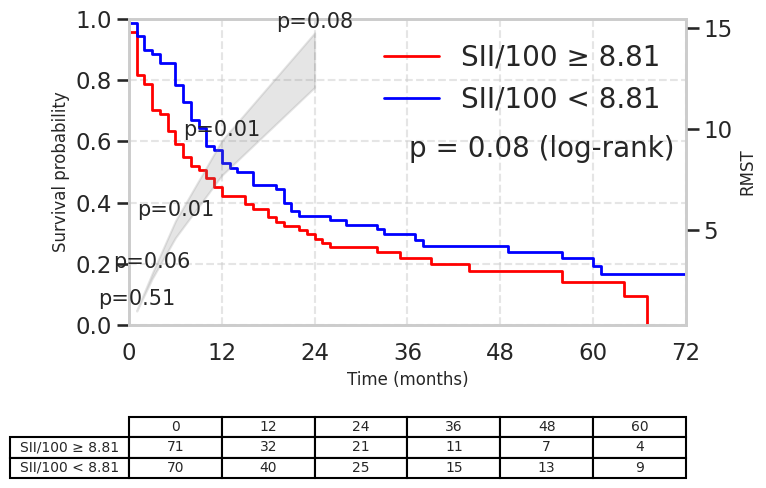

/tmp/ipython-input-3803089870.py:28: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  ax.grid(False, linestyle='--', alpha=0.5)


SIRI_median log-rank p-value: 0.2569


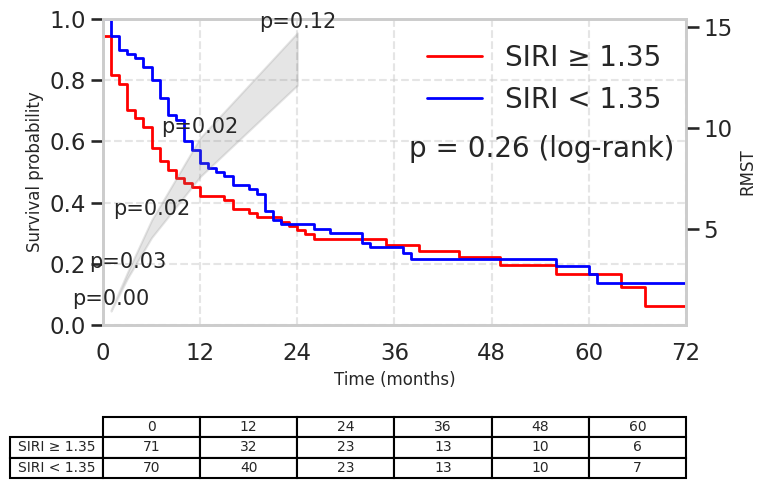

In [ ]:
group_vars = ["SII/100_median", "SIRI_median"]
time_points_rmst = [1, 3, 6, 12, 24]

for group_col in group_vars:
    # Split groups
    group_high = SRS[SRS[group_col] == 1]
    group_low  = SRS[SRS[group_col] == 0]

    # Get the actual median value
    actual_median = SRS[group_col.replace("_median", "")].median()

    # KM curves
    kmf_high = KaplanMeierFitter().fit(group_high["OS_mos"], event_observed=group_high["death"])
    kmf_low  = KaplanMeierFitter().fit(group_low["OS_mos"], event_observed=group_low["death"])

    fig, ax = plt.subplots(figsize=(8,6))

    kmf_high.plot_survival_function(ax=ax, color='red', lw=2,
                                    label=f"{group_col.replace('_median', '')} ≥ {actual_median:.2f}",
                                    ci_show=False)
    kmf_low.plot_survival_function(ax=ax, color='blue', lw=2,
                                   label=f"{group_col.replace('_median', '')} < {actual_median:.2f}",
                                   ci_show=False)

    # KM axis
    ax.set_ylabel("Survival probability", fontsize=12)
    ax.set_ylim(0, 1)
    ax.grid(False, linestyle='--', alpha=0.5)

    # Twin y-axis for RMST
    ax_rmst = ax.twinx()
    rmst_high_list = [restricted_mean_survival_time(kmf_high, t) for t in time_points_rmst]
    rmst_low_list  = [restricted_mean_survival_time(kmf_low, t) for t in time_points_rmst]
    ax_rmst.fill_between(time_points_rmst, rmst_low_list, rmst_high_list, color='gray', alpha=0.2)
    ax_rmst.set_ylabel("RMST", fontsize=12)
    ax_rmst.grid(False)

    # RMST p-values
    pval_list = [bootstrap_rmst_diff(SRS, "OS_mos", "death", group_col, t)[-1]
                 for t in time_points_rmst]
    for t, rmst_h, rmst_l, p in zip(time_points_rmst, rmst_high_list, rmst_low_list, pval_list):
        y_pos = max(rmst_h, rmst_l) + 0.25
        ax_rmst.text(t, y_pos, f"p={p:.2f}", ha='center', fontsize=15)

    # Number at risk table
    max_time = int(np.ceil(SRS["OS_mos"].max()))
    time_points_table = np.array([0, 12, 24, 36, 48, 60])
    n_risk_high = [np.sum(kmf_high.durations >= tp) for tp in time_points_table]
    n_risk_low  = [np.sum(kmf_low.durations >= tp) for tp in time_points_table]

    table = ax.table(cellText=[n_risk_high, n_risk_low],
                     rowLabels=[f'{group_col.replace('_median', '')} ≥ {actual_median:.2f}',
                                f'{group_col.replace('_median', '')} < {actual_median:.2f}'],
                     colLabels=[str(tp) for tp in time_points_table],
                     cellLoc='center', rowLoc='center', colLoc='center',
                     loc='bottom', bbox=[0, -0.5, 1, 0.2])
    table.auto_set_font_size(False)
    table.set_fontsize(10)

    ax.set_xlabel("Time (months)", fontsize=12)
    #ax.set_title(f"KM + RMST by {group_col}", fontsize=14)
    ax.legend(loc='upper right', fontsize=10)
    ax.set_xticks([0, 12, 24, 36, 48, 60, 72])
    ax.set_xlim(0, 72)

    # Log-rank test
    results = logrank_test(group_high["OS_mos"], group_low["OS_mos"],
                           event_observed_A=group_high["death"],
                           event_observed_B=group_low["death"])

    # Legend
    leg = ax.legend(loc='upper right', fontsize=20, frameon=False)

    # Add log-rank p-value text right below legend
    ax.text(0.98, 0.55, f"p = {results.p_value:.2f} (log-rank)",
            transform=ax.transAxes, ha='right', fontsize=20)

    print(f"{group_col} log-rank p-value: {results.p_value:.4f}")

    plt.tight_layout()
    plt.show()

SII_median log-rank p-value: 0.0846
SIRI_median log-rank p-value: 0.2569


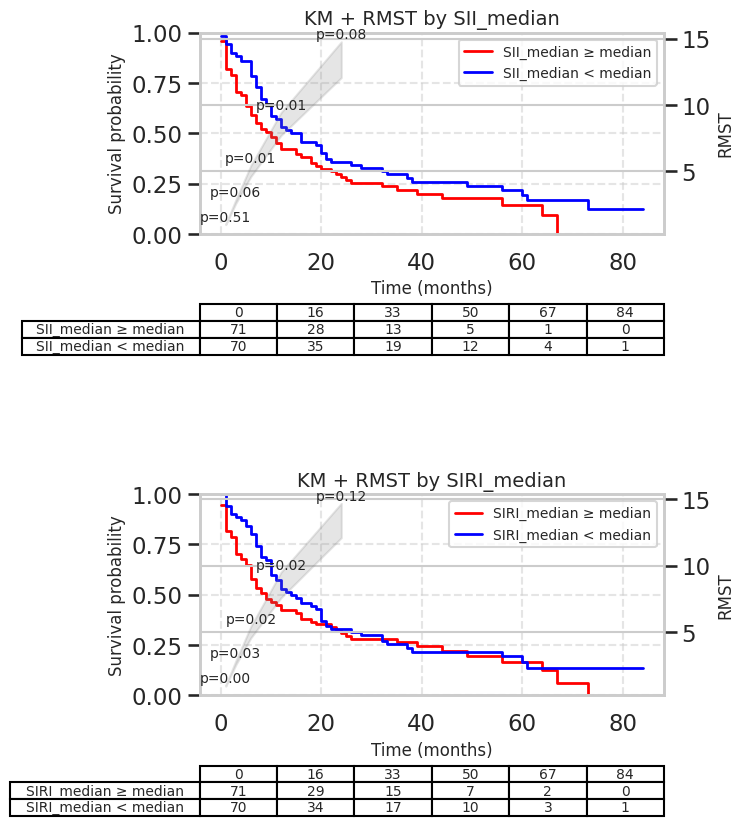

In [ ]:
"""This is not ideal in regards to the layout"""

group_vars = ["SII_median", "SIRI_median"]
time_points_rmst = [1, 3, 6, 12, 24]  # months for RMST

fig, axes = plt.subplots(2, 1, figsize=(8,10), sharey=False)

for ax, group_col in zip(axes, group_vars):
    # Split groups
    group_high = SRS[SRS[group_col] == 1]
    group_low  = SRS[SRS[group_col] == 0]

    # KM curves
    kmf_high = KaplanMeierFitter().fit(group_high["OS_mos"], event_observed=group_high["death"])
    kmf_low  = KaplanMeierFitter().fit(group_low["OS_mos"], event_observed=group_low["death"])
    kmf_high.plot_survival_function(ax=ax, color='red', lw=2, label=f'{group_col} ≥ median', ci_show=False)
    kmf_low.plot_survival_function(ax=ax, color='blue', lw=2, label=f'{group_col} < median', ci_show=False)

    # KM axis
    ax.set_ylabel("Survival probability", fontsize=12)
    ax.set_ylim(0, 1)
    ax.grid(True, linestyle='--', alpha=0.5)

    # Twin y-axis for RMST
    ax_rmst = ax.twinx()
    rmst_high_list = [restricted_mean_survival_time(kmf_high, t) for t in time_points_rmst]
    rmst_low_list  = [restricted_mean_survival_time(kmf_low, t) for t in time_points_rmst]
    ax_rmst.fill_between(time_points_rmst, rmst_low_list, rmst_high_list, color='gray', alpha=0.2)
    ax_rmst.set_ylabel("RMST", fontsize=12)
    ax_rmst.set_axisbelow(True)

    # Compute RMST p-values for this group at each time point
    pval_list = [bootstrap_rmst_diff(SRS, "OS_mos", "death", group_col, t)[-1]
                 for t in time_points_rmst]

    # Annotate RMST p-values above shaded area
    for t, rmst_h, rmst_l, p in zip(time_points_rmst, rmst_high_list, rmst_low_list, pval_list):
        y_pos = max(rmst_h, rmst_l) + 0.25
        ax_rmst.text(t, y_pos, f"p={p:.2f}", ha='center', fontsize=10)

    # Number at risk table
    max_time = int(np.ceil(SRS["OS_mos"].max()))
    time_points_table = np.linspace(0, max_time, 6, dtype=int)
    n_risk_high = [np.sum(kmf_high.durations >= tp) for tp in time_points_table]
    n_risk_low  = [np.sum(kmf_low.durations >= tp) for tp in time_points_table]

    table = ax.table(cellText=[n_risk_high, n_risk_low],
                     rowLabels=[f'{group_col} ≥ median', f'{group_col} < median'],
                     colLabels=[str(tp) for tp in time_points_table],
                     cellLoc='center', rowLoc='center', colLoc='center',
                     loc='bottom', bbox=[0, -0.6, 1, 0.25])
    table.auto_set_font_size(False)
    table.set_fontsize(10)

    ax.set_xlabel("Time (months)", fontsize=12)
    ax.set_title(f"KM + RMST by {group_col}", fontsize=14)
    ax.legend(loc='upper right', fontsize=10)
    ax.set_axisbelow(True)
    ax.grid(True, linestyle='--', alpha=0.5)

    # Log-rank test
    results = logrank_test(group_high["OS_mos"], group_low["OS_mos"],
                           event_observed_A=group_high["death"],
                           event_observed_B=group_low["death"])
    print(f"{group_col} log-rank p-value: {results.p_value:.4f}")

plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

In [ ]:
def plot_km_by_column(df, group_col, time_col, event_col, title=None, intervals=5):
    """
    Plot Kaplan-Meier curves for two groups defined by a boolean/categorical column,
    add median survival, number at risk table, and perform log-rank test.

    Parameters
    ----------
    df : pd.DataFrame
        Data containing event/time and group column.
    group_col : str
        Column name defining two groups (boolean or 0/1 or True/False).
    time_col : str
        Column name for time to event.
    event_col : str
        Column name for event indicator (1=event, 0=censored).
    title : str, optional
        Title for the plot. If None, defaults to group_col name.
    intervals : int
        Number of intervals for number-at-risk table.
    """

    # Ensure group column is boolean
    df[group_col] = df[group_col].astype(bool)

    group_high = df[df[group_col]]
    group_low = df[~df[group_col]]

    kmf_high = KaplanMeierFitter()
    kmf_low = KaplanMeierFitter()

    kmf_high.fit(durations=group_high[time_col], event_observed=group_high[event_col], label=f"{group_col} = True")
    kmf_low.fit(durations=group_low[time_col], event_observed=group_low[event_col], label=f"{group_col} = False")

    # Time points for number at risk table
    max_time = int(np.ceil(df[time_col].max()))
    time_points = np.linspace(0, max_time, intervals+1, dtype=int)

    def num_at_risk(kmf, times):
        return [np.sum(kmf.durations >= t) for t in times]

    n_risk_high = num_at_risk(kmf_high, time_points)
    n_risk_low = num_at_risk(kmf_low, time_points)

    # Plot KM curves
    fig, ax = plt.subplots(figsize=(8,6))
    kmf_high.plot_survival_function(ax=ax, color='red', lw=2)
    kmf_low.plot_survival_function(ax=ax, color='blue', lw=2)

    # Median survival lines
    for kmf, color in zip([kmf_high, kmf_low], ['red','blue']):
        median = kmf.median_survival_time_
        plt.axhline(0.5, color='gray', linestyle='--', lw=1)
        plt.axvline(median, color=color, linestyle='--', lw=1)
        plt.text(median, 0.52, f"{median:.1f} mo", color=color, fontsize=10)

    # Labels
    if title is None:
        title = f"Kaplan-Meier Curve by {group_col}"
    plt.title(title)
    plt.xlabel("Time (months)")
    plt.ylabel("Survival probability")

    # Number at risk table
    cell_text = [
        [str(n) for n in n_risk_high],
        [str(n) for n in n_risk_low]
    ]
    rows = [f"{group_col} = True", f"{group_col} = False"]
    cols = [str(t) for t in time_points]

    the_table = plt.table(cellText=cell_text,
                          rowLabels=rows,
                          colLabels=cols,
                          cellLoc='center',
                          rowLoc='center',
                          colLoc='center',
                          loc='bottom',
                          bbox=[0, -0.3, 1, 0.2])

    the_table.auto_set_font_size(False)
    the_table.set_fontsize(10)

    plt.subplots_adjust(left=0.1, bottom=0.1)
    plt.show()

    # Log-rank test
    results = logrank_test(group_high[time_col], group_low[time_col],
                           event_observed_A=group_high[event_col],
                           event_observed_B=group_low[event_col])

    print(f"Log-rank test p-value: {results.p_value:.4f}")
    return results


In [ ]:
SRS["LMR_3.68"] = SRS.NLR>=3.68

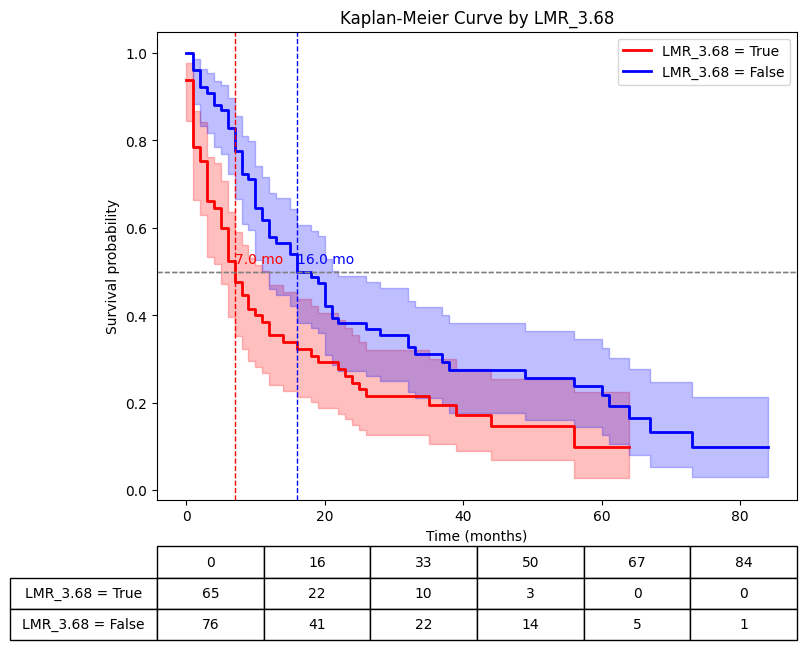

Log-rank test p-value: 0.0065


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           7.41 0.01      7.27

In [ ]:
plot_km_by_column(SRS, "LMR_3.68", "OS_mos", "death", intervals=5)

In [ ]:
# List of cutoff columns
cutoff_cols = ["SIRI_1.6", "PLR_271", "SII_2600", "NLR_1.8", "LMR_3.68"]

# Create new column: 1 if patient meets 3 or more cutoffs
SRS["n_cutoff"] = (SRS[cutoff_cols].sum(axis=1) >= 2).astype(int)

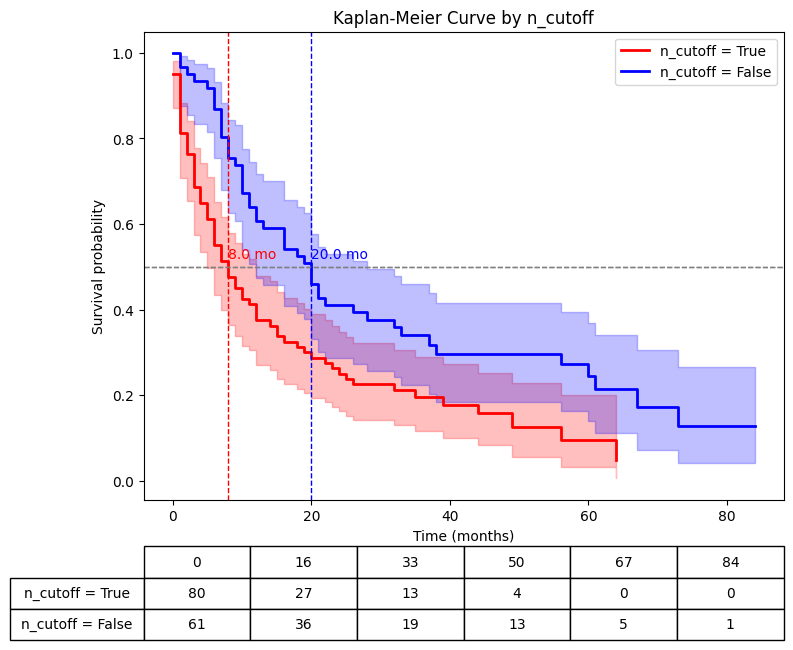

Log-rank test p-value: 0.0017


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
           9.81 <0.005      9.17

In [ ]:
plot_km_by_column(SRS, "n_cutoff", "OS_mos", "death")

# Cox

Since SII and SIRI violate the assumption of Cox hazard, I use logistic regression

In [ ]:
### Cox regression analysis; subgroup analysis on steroid###

dataframe = SRS[SRS.local_failure < 2].copy()

features = ["age", "male",
            "origin_1", "origin_2", "origin_4",
            "n_mets", "BG", "pfossa", "n_ca",
            "NLR", "PLR", "LMR", "SII", "SIRI",
            "fx"]
time_col = "PFS_mos"
event_col = "local_failure"

results = []

for feature in features:
    cph = CoxPHFitter()
    df_sub = dataframe[[time_col, event_col, feature]].dropna()
    cph.fit(df_sub, duration_col=time_col, event_col=event_col)

    # summary info
    summary = cph.summary.loc[feature]

    # Schoenfeld residual PH test
    schoenfeld_test = proportional_hazard_test(cph, df_sub, time_transform='rank')
    schoenfeld_p = schoenfeld_test.summary.loc[feature, 'p']

    results.append({
        "variable": feature,
        "exp(coef)": summary["exp(coef)"],
        "lower95%": summary["exp(coef) lower 95%"],
        "upper95%": summary["exp(coef) upper 95%"],
        "p": summary["p"],
        "PH_test_p": schoenfeld_p
    })

univ_results = pd.DataFrame(results)
print(univ_results)
print(len(dataframe))

"""
PH_test_p = p-value from Schoenfeld residuals test (for violation of proportional hazards).
If PH_test_p < 0.05, PH assumption may be violated for that variable.
"""

summary_table = pd.DataFrame({
    "n": [len(dataframe)],
    "events": [dataframe[event_col].sum()],
    "censored": [(dataframe[event_col] == 0).sum()]
})

print(summary_table)

/usr/local/lib/python3.12/dist-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/usr/local/lib/python3.12/dist-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/usr/local/lib/python3.12/dist-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/usr/local/lib/python3.12/dist-packages/lifelines/utils

    variable  exp(coef)  lower95%  upper95%         p  PH_test_p
0        age   1.001948  0.962421  1.043099  0.924491   0.689631
1       male   1.928764  0.755724  4.922605  0.169416   0.401298
2   origin_1   1.410358  0.408519  4.869079  0.586513   0.559893
3   origin_2   2.950587  0.936388  9.297388  0.064642   0.221053
4   origin_4   1.929556  0.619713  6.007923  0.256691   0.867019
5     n_mets   0.698993  0.339029  1.441151  0.332018   0.716988
6     pfossa   2.797001  1.037685  7.539102  0.042044   0.820987
7       n_ca   1.614702  0.369868  7.049162  0.523977   0.775608
8        NLR   0.988022  0.861637  1.132946  0.863004   0.063473
9        PLR   0.999380  0.995438  1.003337  0.758368   0.149725
10       LMR   0.996744  0.813895  1.220672  0.974839   0.043138
11       SII   0.999853  0.999347  1.000359  0.568697   0.127389
12      SIRI   0.953447  0.761669  1.193513  0.677371   0.113885
13        fx   1.345518  1.069846  1.692223  0.011176   0.420215
109
     n  events  censo

/usr/local/lib/python3.12/dist-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


In [ ]:
### Cox regression analysis (multivariable, stepwise); cancer origin ###

#dataframe = SRS.copy()
#features = ["age", "male", "steroid", "n_mets", "SIRI"]
dataframe = SRS[SRS.local_failure < 2].copy()
features = ["pfossa", "fx"]
time_col = "PFS_mos"
event_col = "local_failure"

final_model, multiv_results = stepwise_cox_lr(dataframe, features, time_col, event_col, p_enter=0.05)

if final_model is not None:
    print("Selected variables (in order added):")
    print(list(multiv_results["variable"]))
    print("\nMultivariable model summary (selected vars):")
    print(multiv_results)
    print("\nFull lifelines summary:")
    print(final_model.summary)
else:
    print("No variables entered the model with the specified p_enter threshold.")

/usr/local/lib/python3.12/dist-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/usr/local/lib/python3.12/dist-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/usr/local/lib/python3.12/dist-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/usr/local/lib/python3.12/dist-packages/lifelines/utils

Selected variables (in order added):
['fx']

Multivariable model summary (selected vars):
  variable  exp(coef)  lower95%  upper95%  p (Wald)  LR_enter_p  PH_test_p
0       fx   1.345518  1.069846  1.692223  0.011176    0.011176   0.420215

Full lifelines summary:
               coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
fx         0.296779   1.345518  0.116974        0.067515        0.526043   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                               
fx                    1.069846             1.692223     0.0  2.537143   

                  p  -log2(p)  
covariate                      
fx         0.011176  6.483438  


/usr/local/lib/python3.12/dist-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/usr/local/lib/python3.12/dist-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
